In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')

**Link**: [Brazilian E-Commerce Public Dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce)

**Brazilian E-Commerce Public Dataset by Olist**

Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

---
## **1. EXPLORE THE DATA TO GAIN INSIGHTS**
---

In [2]:
product_cat = pd.read_csv("data/product_category_name_translation.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")
items = pd.read_csv("data/olist_order_items_dataset.csv")
payments = pd.read_csv("data/olist_order_payments_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
sellers = pd.read_csv("data/olist_sellers_dataset.csv")

In [3]:
customers["customer_zip_code_prefix"] = customers["customer_zip_code_prefix"].astype("object")
geolocation = geolocation[geolocation["geolocation_lat"] <= 5.27438888]
geolocation = geolocation[geolocation["geolocation_lng"] >= -73.98283055]
geolocation = geolocation[geolocation["geolocation_lat"] >= -33.75116944]
geolocation = geolocation[geolocation["geolocation_lng"] <=  -34.79314722]
items["shipping_limit_date"] = pd.to_datetime(items["shipping_limit_date"])
items["shipping_limit"] = items["shipping_limit_date"].dt.date
items["shipping_limit"] = pd.to_datetime(items["shipping_limit"])
items["total_order_value"] = items["order_item_id"] * (items["price"] + items["freight_value"])
items = items[items["shipping_limit"] < "2020"]
reviews["review_answer_date"] = reviews["review_answer_timestamp"].map(lambda x: x[:10])
reviews["review_creation_date"] = pd.to_datetime(reviews["review_creation_date"])
reviews["review_answer_timestamp"] = pd.to_datetime(reviews["review_answer_timestamp"])
reviews["review_answer_date"] = pd.to_datetime(reviews["review_answer_date"])
reviews = reviews.sort_values("review_creation_date")
for i in range(5):
    orders[orders.columns[3 + i]] = pd.to_datetime(orders[orders.columns[3 + i]])
orders.rename(columns = {"order_purchase_timestamp": "purchase_ts", "order_delivered_customer_date": "delivered_date", "order_estimated_delivery_date": "estimated_date"}, inplace = True)
orders = orders.drop(["order_approved_at", "order_delivered_carrier_date"], axis = 1)
orders["purchase_date"] = pd.to_datetime(orders["purchase_ts"].dt.date)
orders["purchase_date_num"] = orders["purchase_ts"].dt.day.astype("object")
orders["purchase_day_num"] = orders["purchase_ts"].dt.weekday.astype("object")
orders["purchase_month"] = pd.to_datetime(orders["purchase_date"].dt.strftime('%Y-%m-01'))
orders["purchase_month_num"] = orders["purchase_ts"].dt.month.astype("object")
orders["purchase_year"] = pd.to_datetime(orders["purchase_date"].dt.strftime('%Y-01-01'))
orders["purchase_week"] = pd.to_timedelta(orders["purchase_ts"].dt.weekday, unit = "D")
orders["purchase_week"] = orders["purchase_date"] - orders["purchase_week"]
orders["purchase_hour"] = orders["purchase_ts"].dt.hour.astype("object")
orders["delivered_date"] = pd.to_datetime(orders["delivered_date"].dt.date)
orders["estimated_date"] = pd.to_datetime(orders["estimated_date"].dt.date)
orders["delivery_day"] = (orders["delivered_date"] - orders["purchase_date"]).dt.days
orders["estimated_day"] = (orders["delivered_date"] - orders["estimated_date"]).dt.days
orders = orders.sort_values("purchase_ts")
products["product_volume"] = products["product_length_cm"] * products["product_height_cm"] * products["product_width_cm"]

In [4]:
cust_ord_df = pd.merge(customers, orders, left_on = "customer_id", right_on = "customer_id", how = "inner")
ord_items_df = pd.merge(cust_ord_df, items, how = "left", left_on = "order_id", right_on = "order_id")
new_products = pd.merge(products, product_cat, how = "left", on = "product_category_name")
ord_items_df = pd.merge(ord_items_df, new_products, how = "left", left_on = "product_id", right_on = "product_id")
ord_items_df = pd.merge(ord_items_df, payments, how = "left", left_on = "order_id", right_on = "order_id")
ord_items_df = pd.merge(ord_items_df, reviews, how = "left", left_on = "order_id", right_on = "order_id")
ord_items_df = pd.merge(ord_items_df, sellers, how = "left", left_on = "seller_id", right_on = "seller_id")

In [5]:
ord_items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119150 entries, 0 to 119149
Data columns (total 52 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119150 non-null  object        
 1   customer_unique_id             119150 non-null  object        
 2   customer_zip_code_prefix       119150 non-null  object        
 3   customer_city                  119150 non-null  object        
 4   customer_state                 119150 non-null  object        
 5   order_id                       119150 non-null  object        
 6   order_status                   119150 non-null  object        
 7   purchase_ts                    119150 non-null  datetime64[ns]
 8   delivered_date                 115729 non-null  datetime64[ns]
 9   estimated_date                 119150 non-null  datetime64[ns]
 10  purchase_date                  119150 non-null  datetime64[ns]
 11  

In [6]:
data = ord_items_df.drop(["shipping_limit_date", "shipping_limit", "review_creation_date", "review_answer_timestamp", "review_answer_date", "delivered_date", "estimated_date"], axis = 1)

In [7]:
def ma_calculate(data, window = 1, min_periods = 1, thresholds = 2):
    mean = pd.DataFrame(data.rolling(window = window, min_periods = min_periods).mean())
    std = pd.DataFrame(data.rolling(window = window, min_periods = min_periods).std())
    upper_band= mean + thresholds * std
    lower_band= mean - thresholds * std
    anomaly_index = np.where((data > upper_band) | (data < lower_band))[0]
    return mean, std, upper_band, lower_band, anomaly_index

In [8]:
print(f'Total Customers = {data["customer_unique_id"].nunique()}')
print(f'Total Sellers = {data["seller_id"].nunique()}')
print(f'Total Cities = {data["customer_city"].nunique()}')

Total Customers = 96096
Total Sellers = 3095
Total Cities = 4119


- There is an anomaly in the beginning of 2018 where number purchase in that week increase and become the highest number purchase for the e-commerce. After that week, the purchase number fall and then increase again. BUt if calculate the purchase month by month, the data show positive trend and there is no anomaly from the purchase activity.
- The most number customers and sellers from this e-commerce is in Sao Paulo,more than 40000 customers followed by Rio De Janeiro. From this data we know that Sao Paulo become the main area for this e-commerce. This area become the highest revenue contribution.
- There are 32950 porduct with 73 product category has been sold by this e-commerce.
- By category, Bed & Bath, Sports, Furniture and Health become the most product that customers have bought.
- Total payment that this e-commerce get is around 20M, total cost around 19M, and then the profit around 1M. So far, number order that have been palced is 99441 orders.
- Since 2016, total payment that the e-commerce get increase, especially from 2016 to 2017. In 2018, the total payment that e-commerce get is around 10K to 100K per week.
- If we average number order by day, most orders come in weekdays rather than weekend. The best day to e-commerce to place an advertising and doing marketing to the customers is in weekday.
- Bu payment type, most cutomers use credit card as the payment method followed by Boleto (is payment method in Brazil regulated by FEBRABAN, Brazilian Federation of Banks).
- For review score, most of the customer gave 5 star rating for the service.
- Let's take look by region, SP have the highest payment (number customer also the highest, so make sense if SP have highest payment).

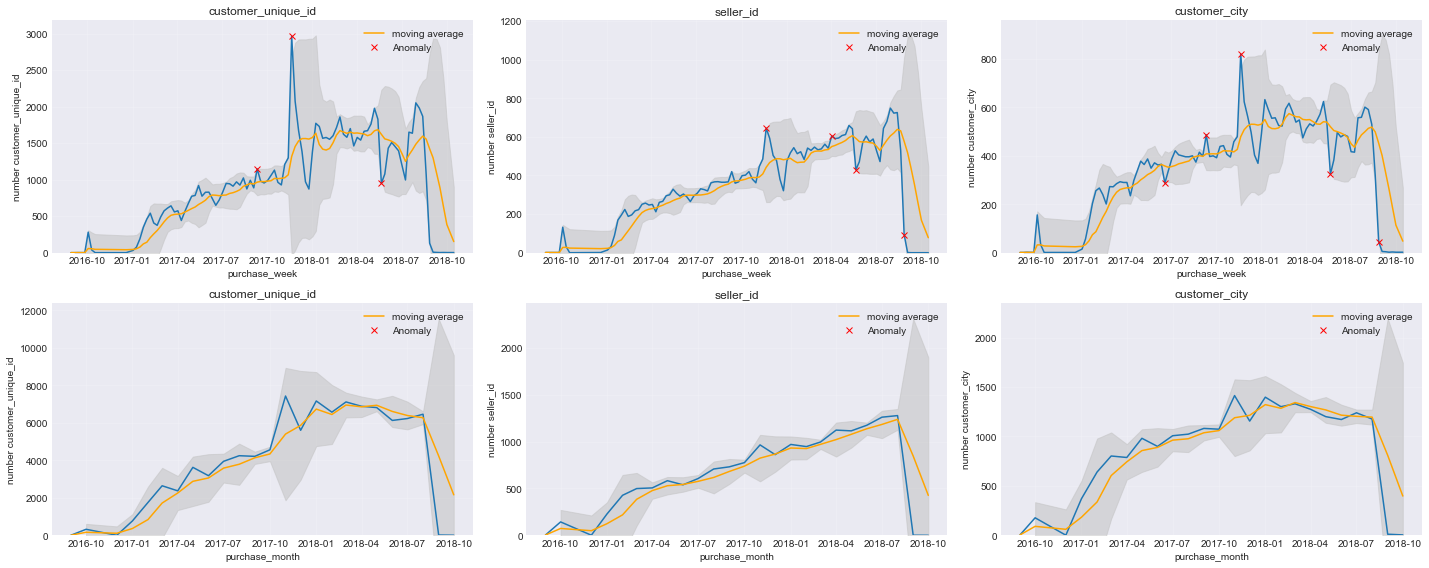

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
columns = ["customer_unique_id", "seller_id", "customer_city"]
features = {0: ["purchase_week", 8], 1: ["purchase_month", 3]}
for column in range(len(columns)):
    for key, value in features.items():
        data_graph = pd.DataFrame(data.groupby(value[0]).nunique()[columns[column]])
        mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
        ax[key, column].plot(data_graph.index, data_graph)
        ax[key, column].plot(mean.index, mean, color = "orange", label = "moving average")
        ax[key, column].fill_between(x = mean.index, y1 = lower_band[columns[column]], y2 = upper_band[columns[column]], color = "silver", alpha = 0.5)
        ax[key, column].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
        ax[key, column].grid(alpha = 0.2)
        ax[key, column].set_ylim(0)
        ax[key, column].legend()
        ax[key, column].set_title(columns[column])
        ax[key, column].set_xlabel(value[0])
        ax[key, column].set_ylabel(f"number {columns[column]}")
plt.tight_layout()
plt.show()

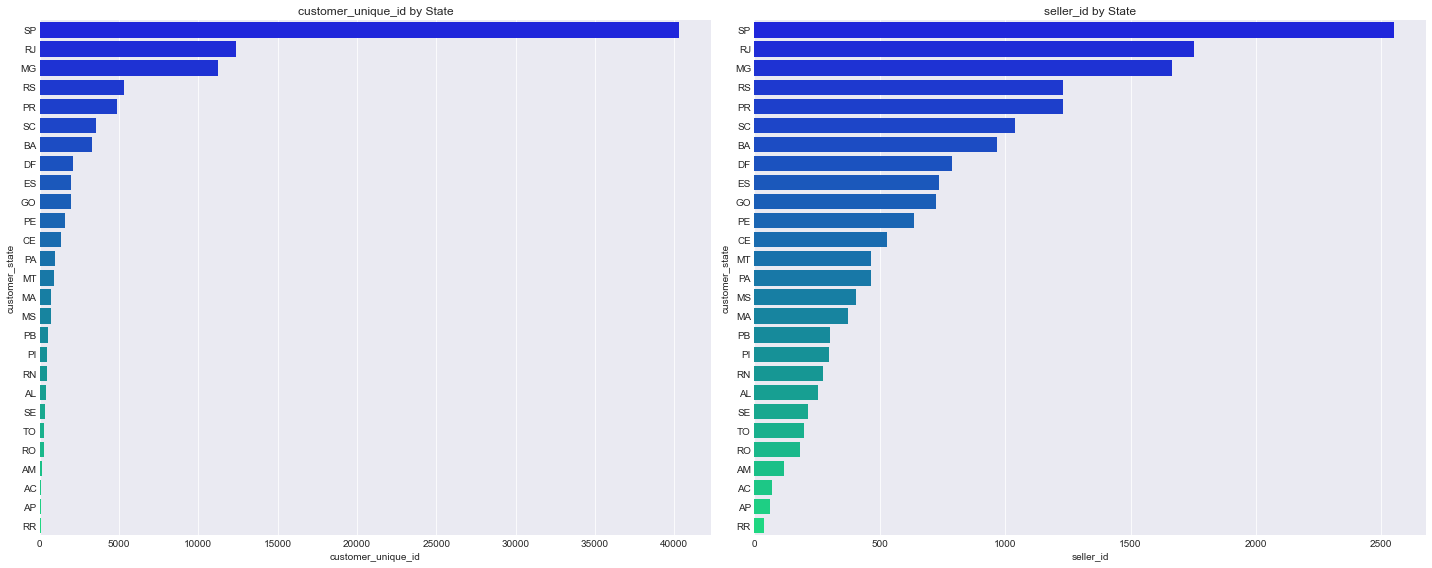

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
cust_sell = ["customer_unique_id", "seller_id"]
for cs in range(len(cust_sell)):
    data_graph = data.groupby("customer_state").nunique()[cust_sell[cs]].sort_values(ascending = False)
    sns.barplot(x = data_graph, y = data_graph.index, ax = ax[cs], palette = "winter")
    ax[cs].set_title(cust_sell[cs] + " by State")
plt.tight_layout()
plt.show()

In [11]:
ord_items_df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'purchase_ts', 'delivered_date', 'estimated_date', 'purchase_date',
       'purchase_date_num', 'purchase_day_num', 'purchase_month',
       'purchase_month_num', 'purchase_year', 'purchase_week', 'purchase_hour',
       'delivery_day', 'estimated_day', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'shipping_limit', 'total_order_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_volume',
       'product_category_name_english', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_cre

In [12]:
print(f'Total Products = {data["product_id"].nunique()}')
print(f'Total Products Category = {data["product_category_name"].nunique()}')

Total Products = 32950
Total Products Category = 73


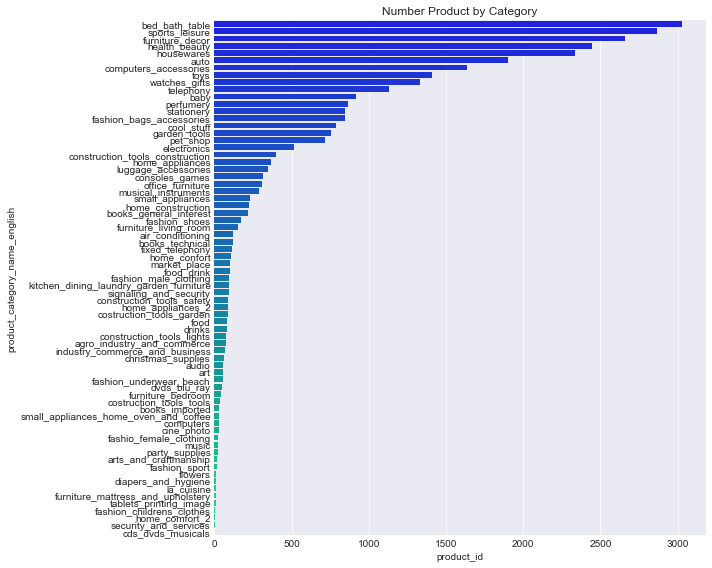

In [13]:
plt.figure(figsize = (10, 8))
data_graph = data.groupby("product_category_name_english").nunique()["product_id"].sort_values(ascending = False)
sns.barplot(x = data_graph, y = data_graph.index, palette = "winter")
plt.title("Number Product by Category")
plt.tight_layout()
plt.show()

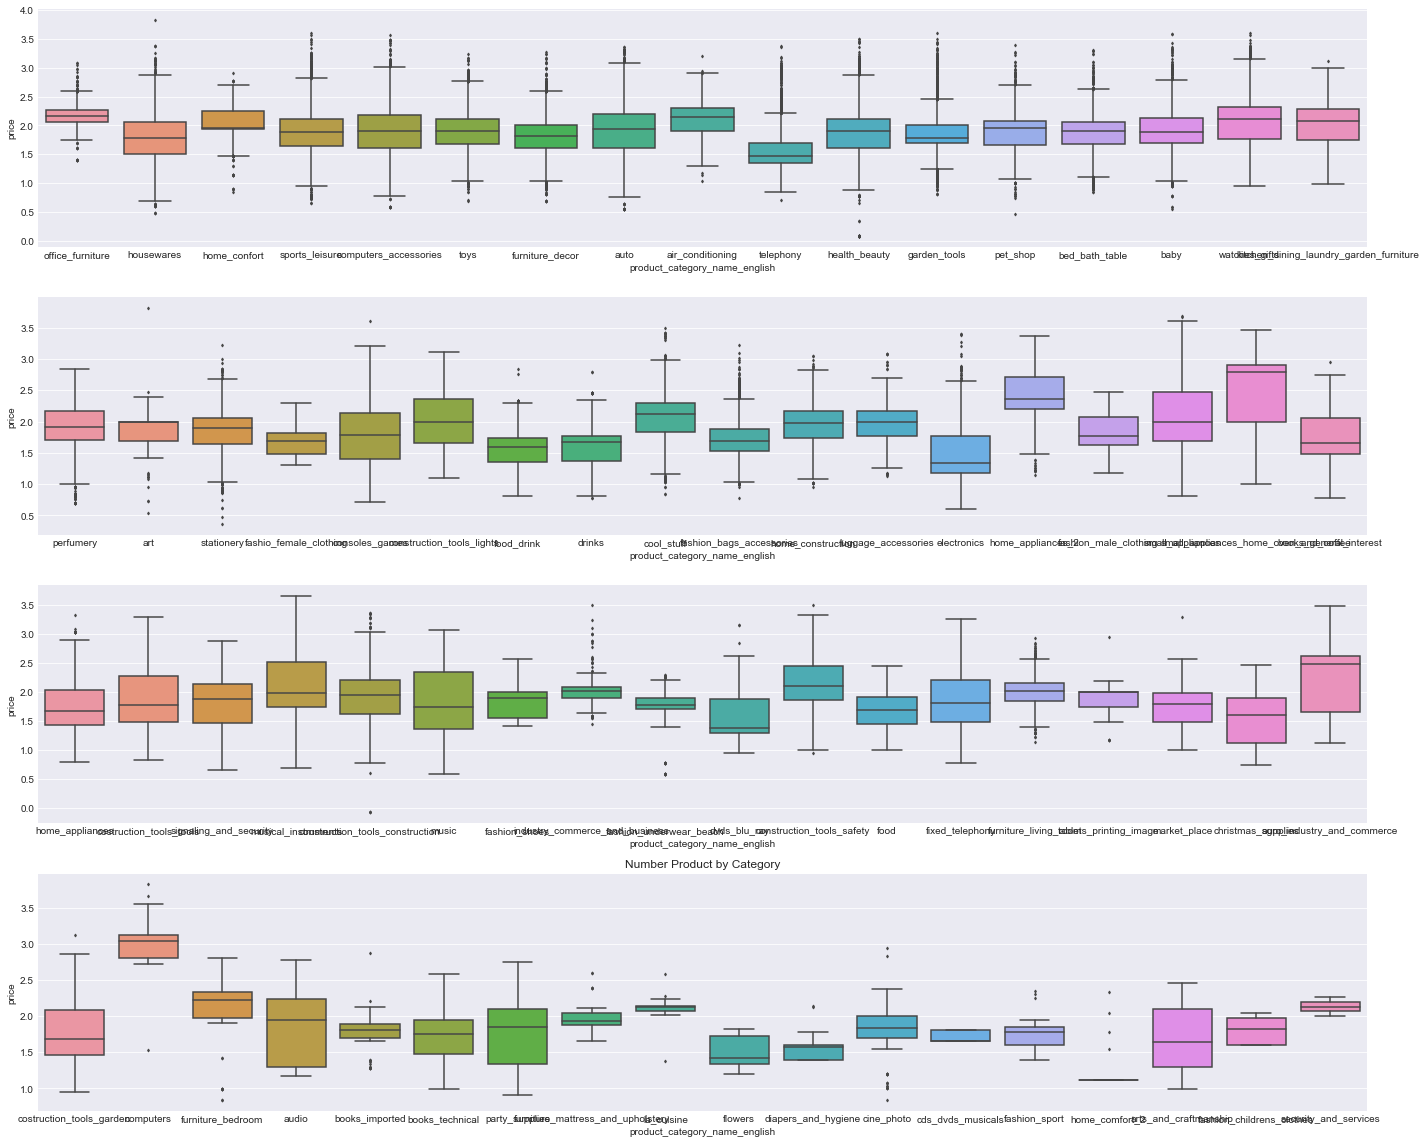

In [14]:
fig, ax = plt.subplots(4, 1, figsize = (20, 16))
types = data["product_category_name_english"].unique()
sns.boxplot(x = "product_category_name_english", y = np.log10(data["price"]), data = data[data["product_category_name_english"].isin(types[:18])], fliersize = 2, ax= ax[0])
sns.boxplot(x = "product_category_name_english", y = np.log10(data["price"]), data = data[data["product_category_name_english"].isin(types[18:36])], fliersize = 2, ax= ax[1])
sns.boxplot(x = "product_category_name_english", y = np.log10(data["price"]), data = data[data["product_category_name_english"].isin(types[36:54])], fliersize = 2, ax= ax[2])
sns.boxplot(x = "product_category_name_english", y = np.log10(data["price"]), data = data[data["product_category_name_english"].isin(types[54:72])], fliersize = 2, ax= ax[3])
plt.title("Number Product by Category")
plt.tight_layout()
plt.show()

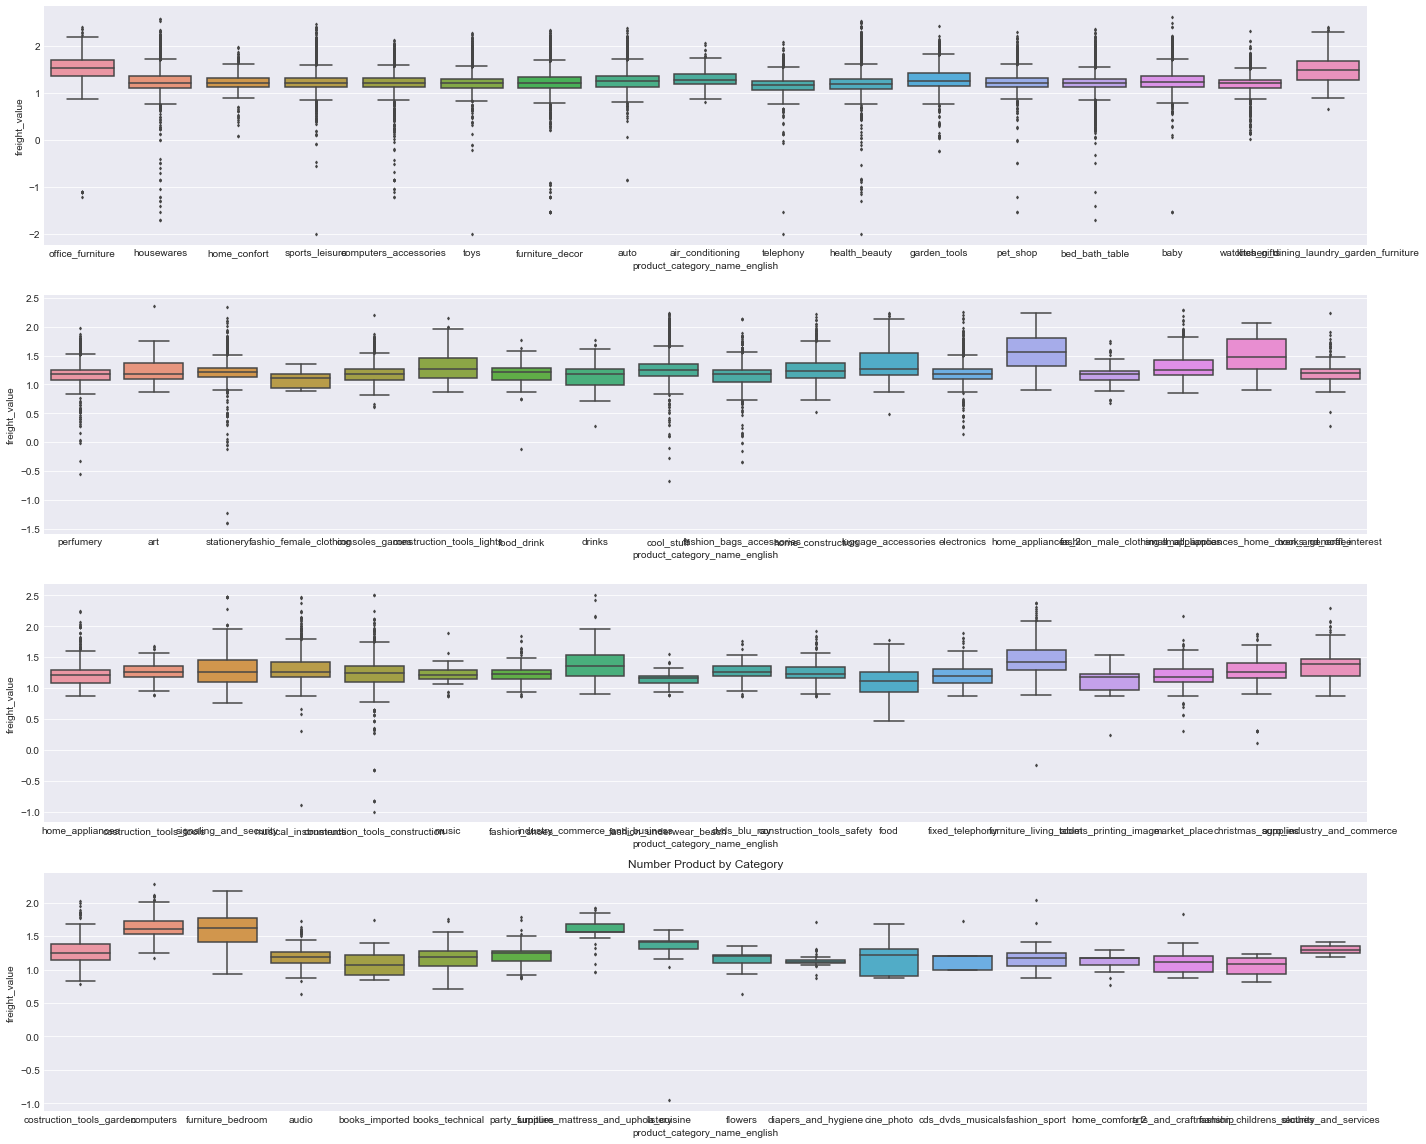

In [15]:
fig, ax = plt.subplots(4, 1, figsize = (20, 16))
types = data["product_category_name_english"].unique()
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["freight_value"] != 0]["freight_value"]), data = data[data["product_category_name_english"].isin(types[:18])], fliersize = 2, ax= ax[0])
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["freight_value"] != 0]["freight_value"]), data = data[data["product_category_name_english"].isin(types[18:36])], fliersize = 2, ax= ax[1])
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["freight_value"] != 0]["freight_value"]), data = data[data["product_category_name_english"].isin(types[36:54])], fliersize = 2, ax= ax[2])
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["freight_value"] != 0]["freight_value"]), data = data[data["product_category_name_english"].isin(types[54:72])], fliersize = 2, ax= ax[3])
plt.title("Number Product by Category")
plt.tight_layout()
plt.show()

In [16]:
print(f'Total Payments \t= {round(data["payment_value"].sum(), 2)}')
print(f'Total Cost \t= {round(data["total_order_value"].sum(), 2)}')
print(f'Total Order \t= {round(data["order_id"].nunique(), 2)}')

Total Payments 	= 20580786.76
Total Cost 	= 18954333.33
Total Order 	= 99441


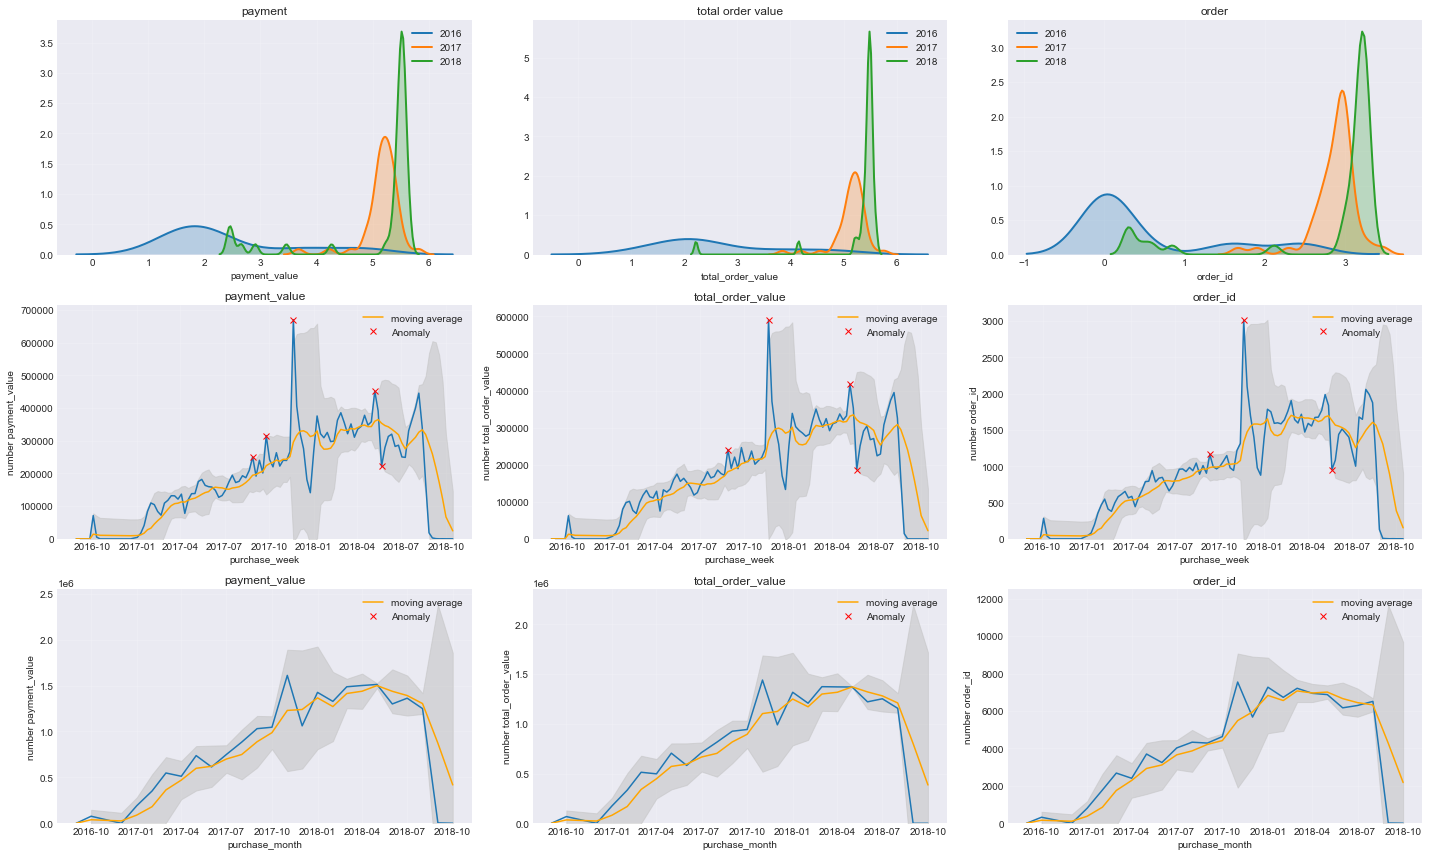

In [17]:
fig, ax = plt.subplots(3, 3, figsize = (20, 12))
for year in range(3):
    sns.distplot(np.log10(data[(data["purchase_year"] == str(2016 + year)) & (data["payment_value"] > 0)].groupby("purchase_week").sum()["payment_value"]),
                 hist = False, kde_kws = {'shade': True, 'linewidth': 2}, label = 2016 + year, ax = ax[0, 0])
    sns.distplot(np.log10(data[(data["purchase_year"] == str(2016 + year)) & (data["total_order_value"] > 0)].groupby("purchase_week").sum()["total_order_value"]),
                 hist = False, kde_kws = {'shade': True, 'linewidth': 2}, label = 2016 + year, ax = ax[0, 1])
    sns.distplot(np.log10(data[data["purchase_year"] == str(2016 + year)].groupby("purchase_week").nunique()["order_id"]),
                 hist = False, kde_kws = {'shade': True, 'linewidth': 2}, label = 2016 + year, ax = ax[0, 2])
ax[0, 0].set_title("payment")
ax[0, 1].set_title("total order value")
ax[0, 2].set_title("order")

ax[0, 0].grid(alpha = 0.2)
ax[0, 1].grid(alpha = 0.2)
ax[0, 2].grid(alpha = 0.2)

columns = ["payment_value", "total_order_value", "order_id"]
features = {0: ["purchase_week", 8], 1: ["purchase_month", 3]}
for column in range(len(columns)):
    for key, value in features.items():
        if columns[column] == "order_id":
            data_graph = pd.DataFrame(data.groupby(value[0]).nunique()[columns[column]])
        else:
            data_graph = pd.DataFrame(data.groupby(value[0]).sum()[columns[column]])
        mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
        ax[key + 1, column].plot(data_graph.index, data_graph)
        ax[key + 1, column].plot(mean.index, mean, color = "orange", label = "moving average")
        ax[key + 1, column].fill_between(x = mean.index, y1 = lower_band[columns[column]], y2 = upper_band[columns[column]], color = "silver", alpha = 0.5)
        ax[key + 1, column].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
        ax[key + 1, column].grid(alpha = 0.2)
        ax[key + 1, column].set_ylim(0)
        ax[key + 1, column].legend()
        ax[key + 1, column].set_title(columns[column])
        ax[key + 1, column].set_xlabel(value[0])
        ax[key + 1, column].set_ylabel(f"number {columns[column]}")
plt.tight_layout()
plt.show()

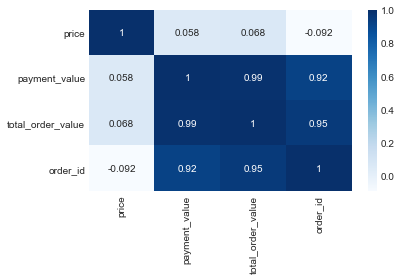

In [18]:
sns.heatmap(data.groupby("purchase_date").agg({"price": "mean", "payment_value": sum, "total_order_value": sum, "order_id": "nunique"}).corr(), annot = True, cmap = "Blues")
plt.tight_layout()
plt.show()

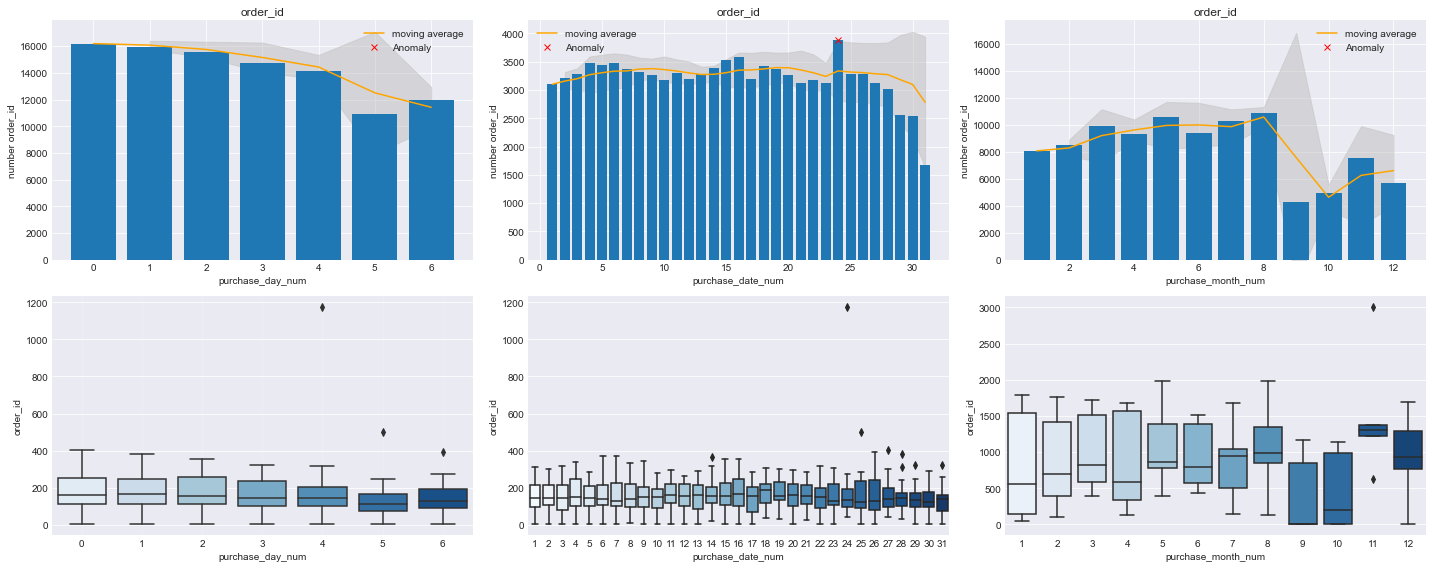

In [19]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
features = {0: ["purchase_day_num", 2], 1: ["purchase_date_num", 7], 2: ["purchase_month_num", 2]}
for key, value in features.items():
    data_graph = pd.DataFrame(data.groupby(value[0]).nunique()["order_id"])
    mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
    ax[0, key].bar(data_graph.index, data_graph["order_id"], width = 0.8)
    ax[0, key].plot(mean.index, mean, color = "orange", label = "moving average")
    ax[0, key].fill_between(x = mean.index, y1 = lower_band["order_id"], y2 = upper_band["order_id"], color = "silver", alpha = 0.5)
    ax[0, key].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
    ax[0, key].set_ylim(0)
    ax[0, key].legend()
    ax[0, key].set_title("order_id")
    ax[0, key].set_xlabel(value[0])
    ax[0, key].set_ylabel(f"number order_id")

data_graph = pd.DataFrame(data.groupby(["purchase_date", "purchase_day_num"]).nunique()["order_id"]).reset_index().drop("purchase_date", axis = 1)
sns.boxplot(x = "purchase_day_num", y = "order_id", data = data_graph, palette = "Blues", ax = ax[1, 0])
data_graph = pd.DataFrame(data.groupby(["purchase_date", "purchase_date_num"]).nunique()["order_id"]).reset_index().drop("purchase_date", axis = 1)
sns.boxplot(x = "purchase_date_num", y = "order_id", data = data_graph, palette = "Blues", ax = ax[1, 1])
data_graph = pd.DataFrame(data.groupby(["purchase_week", "purchase_month_num"]).nunique()["order_id"]).reset_index().drop("purchase_week", axis = 1)
sns.boxplot(x = "purchase_month_num", y = "order_id", data = data_graph, palette = "Blues", ax = ax[1, 2])
ax[1, 0].grid(axis = "x", alpha = 0.2)
plt.tight_layout()
plt.show()

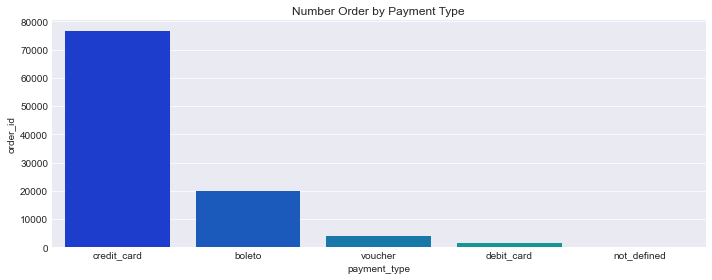

In [20]:
plt.figure(figsize = (10, 4))
data_graph = data.groupby("payment_type").nunique()["order_id"].sort_values(ascending = False)
sns.barplot(y = data_graph, x = data_graph.index, palette = "winter")
plt.title("Number Order by Payment Type")
plt.tight_layout()
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


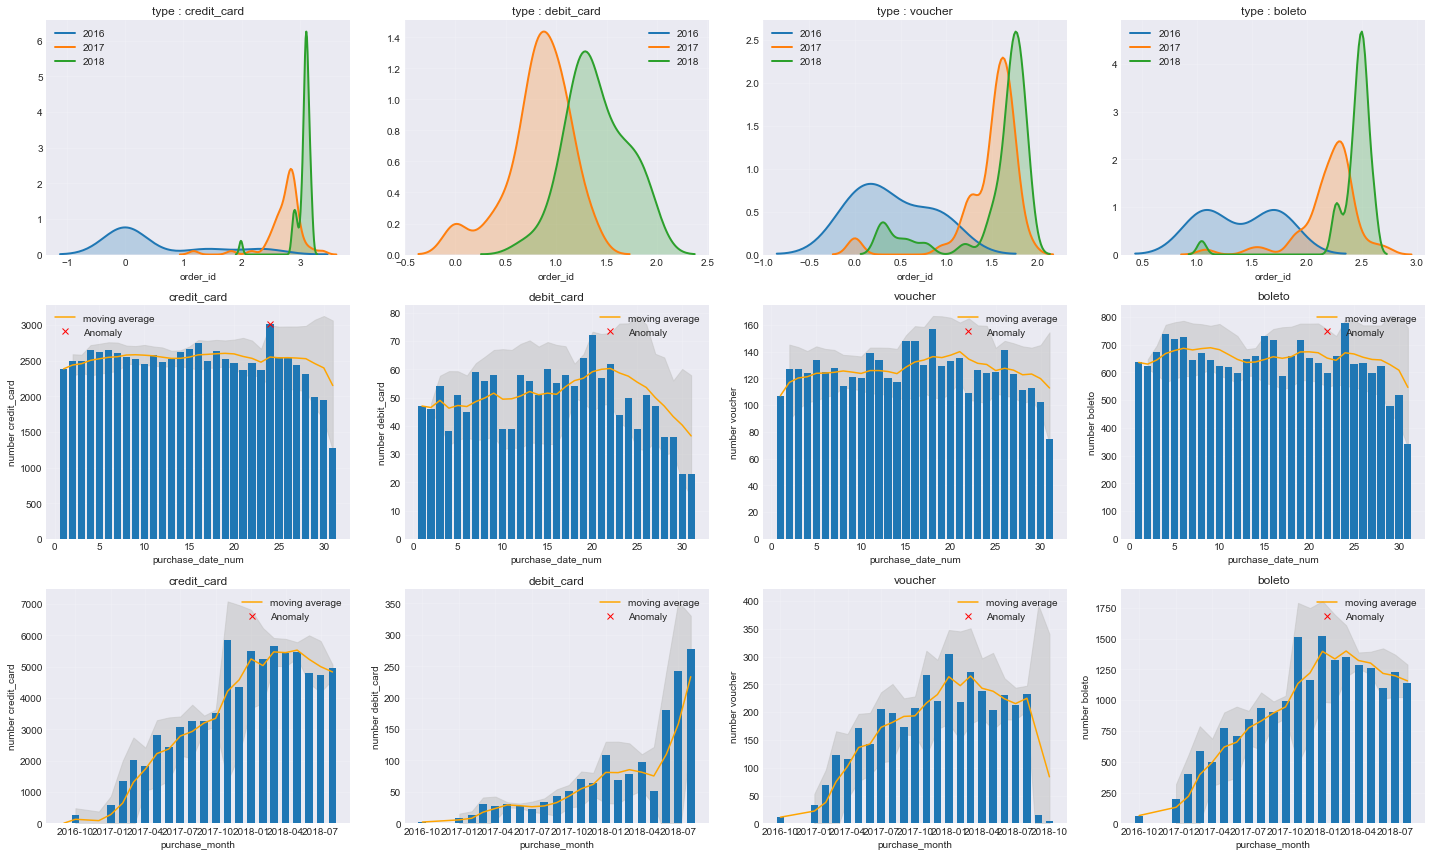

In [21]:
fig, ax = plt.subplots(3, 4, figsize = (20, 12))
types = ["credit_card", "debit_card", "voucher", "boleto"]
for pt in range(len(types)):
    for year in range(3):
        sns.distplot(np.log10(data[(data["payment_type"] == types[pt]) & (data["purchase_year"] == str(2016 + year))].groupby(["purchase_week"]).nunique()["order_id"]),
                     hist = False, kde_kws = {'shade': True, 'linewidth': 2}, label = str(2016 + year), ax = ax[0, pt])
    ax[0, pt].set_title(f"type : {types[pt]}")
    ax[0, pt].grid(alpha = 0.2)

features = {0: ["purchase_date_num", 7, 0.8], 1: ["purchase_month", 3, 20]}
for column in range(len(types)):
    for key, value in features.items():
        data_graph = pd.DataFrame(data[data["payment_type"] == types[column]].groupby(value[0]).nunique()["order_id"])
        mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
        ax[key + 1, column].bar(data_graph.index, data_graph["order_id"], width = value[2])
        ax[key + 1, column].plot(mean.index, mean, color = "orange", label = "moving average")
        ax[key + 1, column].fill_between(x = mean.index, y1 = lower_band["order_id"], y2 = upper_band["order_id"], color = "silver", alpha = 0.5)
        ax[key + 1, column].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
        ax[key + 1, column].grid(alpha = 0.2)
        ax[key + 1, column].set_ylim(0)
        ax[key + 1, column].legend()
        ax[key + 1, column].set_title(types[column])
        ax[key + 1, column].set_xlabel(value[0])
        ax[key + 1, column].set_ylabel(f"number {types[column]}")
plt.tight_layout()
plt.show()

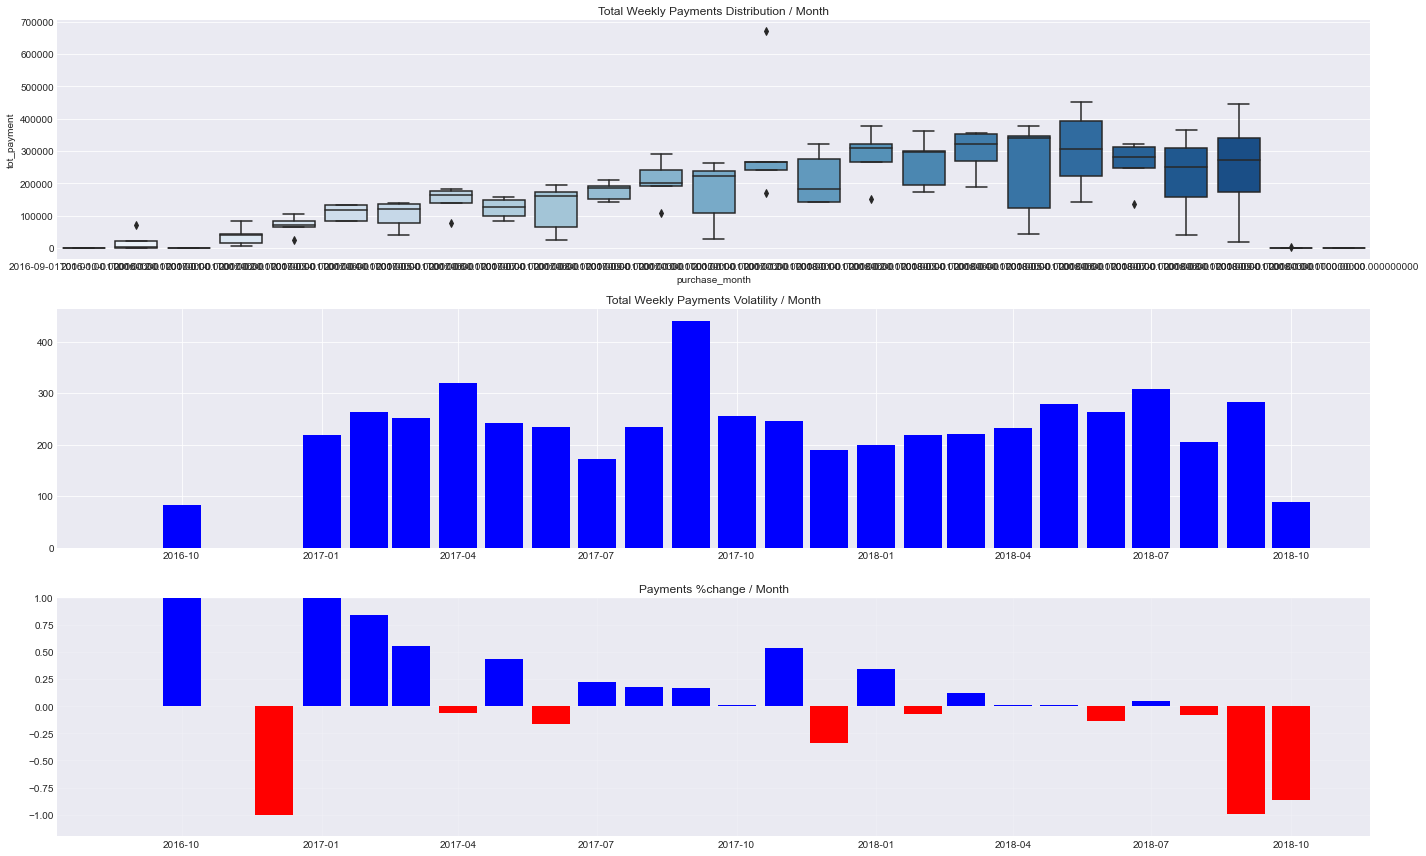

In [22]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))
data_graph = data.groupby(["purchase_month", "purchase_week"]).agg(tot_payment = ("payment_value", sum), std_payment = ("payment_value", "std")).fillna(0)
data_graph = data_graph.reset_index().drop("purchase_week", axis = 1)
sns.boxplot(x = "purchase_month", y = "tot_payment", data = data_graph, palette = "Blues", ax = ax[0])
data_graph = data_graph.groupby("purchase_month").agg({"tot_payment": sum, "std_payment": "mean"}).reset_index()
ax[1].bar(x = "purchase_month", height = "std_payment", data = data_graph, width = 25, color = "blue")
data_graph["tot_change"] = data_graph["tot_payment"].pct_change().fillna(0)
ax[2].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] >= 0], width = 25, color = "blue")
ax[2].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] < 0], width = 25, color = "red")
ax[0].set_title("Total Weekly Payments Distribution / Month")
ax[1].set_title("Total Weekly Payments Volatility / Month")
ax[2].set_title("Payments %change / Month")
ax[2].set_ylim(-1.2, 1)
ax[2].grid(alpha = 0.2)
plt.tight_layout()
plt.show()

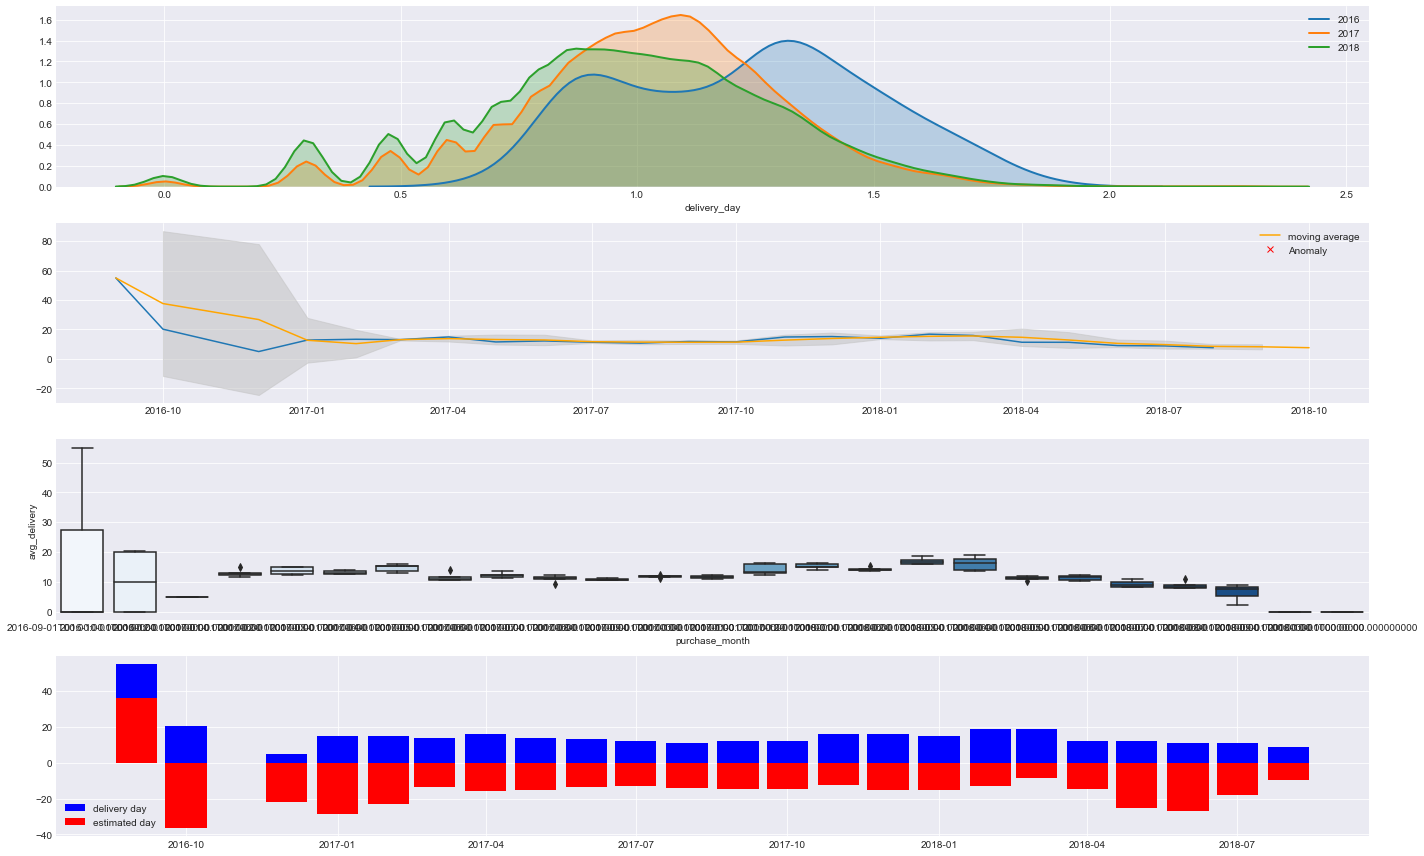

In [23]:
fig, ax = plt.subplots(4, 1, figsize = (20, 12))
for year in range(3):
    sns.distplot(np.log10(data[(data["purchase_year"] == str(2016 + year)) & (data["delivery_day"] > 0)]["delivery_day"]),
                 hist = False, kde_kws = {'shade': True, 'linewidth': 2}, label = 2016 + year, ax = ax[0])
data_graph = pd.DataFrame(data.groupby("purchase_month").mean()["delivery_day"])
mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 3)
ax[1].plot(data_graph.index, data_graph)
ax[1].plot(mean.index, mean, color = "orange", label = "moving average")
ax[1].fill_between(x = mean.index, y1 = lower_band["delivery_day"], y2 = upper_band["delivery_day"], color = "silver", alpha = 0.5)
ax[1].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
ax[1].legend()

data_graph = data.groupby(["purchase_month", "purchase_week"]).agg(avg_delivery = ("delivery_day", "mean"),std_delivery = ("delivery_day", "std")).fillna(0)
data_graph = data_graph.reset_index().drop("purchase_week", axis = 1)
sns.boxplot(x = "purchase_month", y = "avg_delivery", data = data_graph, palette = "Blues", ax = ax[2])
data_graph = data.groupby(["purchase_month", "purchase_week"]).agg({"delivery_day": "mean", "estimated_day": "mean"})
data_graph = data_graph.reset_index().drop("purchase_week", axis = 1)
ax[3].bar(x = "purchase_month", height = "delivery_day", data = data_graph, color = "blue", width = 25, label = "delivery day")
ax[3].bar(x = "purchase_month", height = "estimated_day", data = data_graph, color = "red", width = 25, label = "estimated day")
ax[3].legend()

plt.tight_layout()
plt.show()

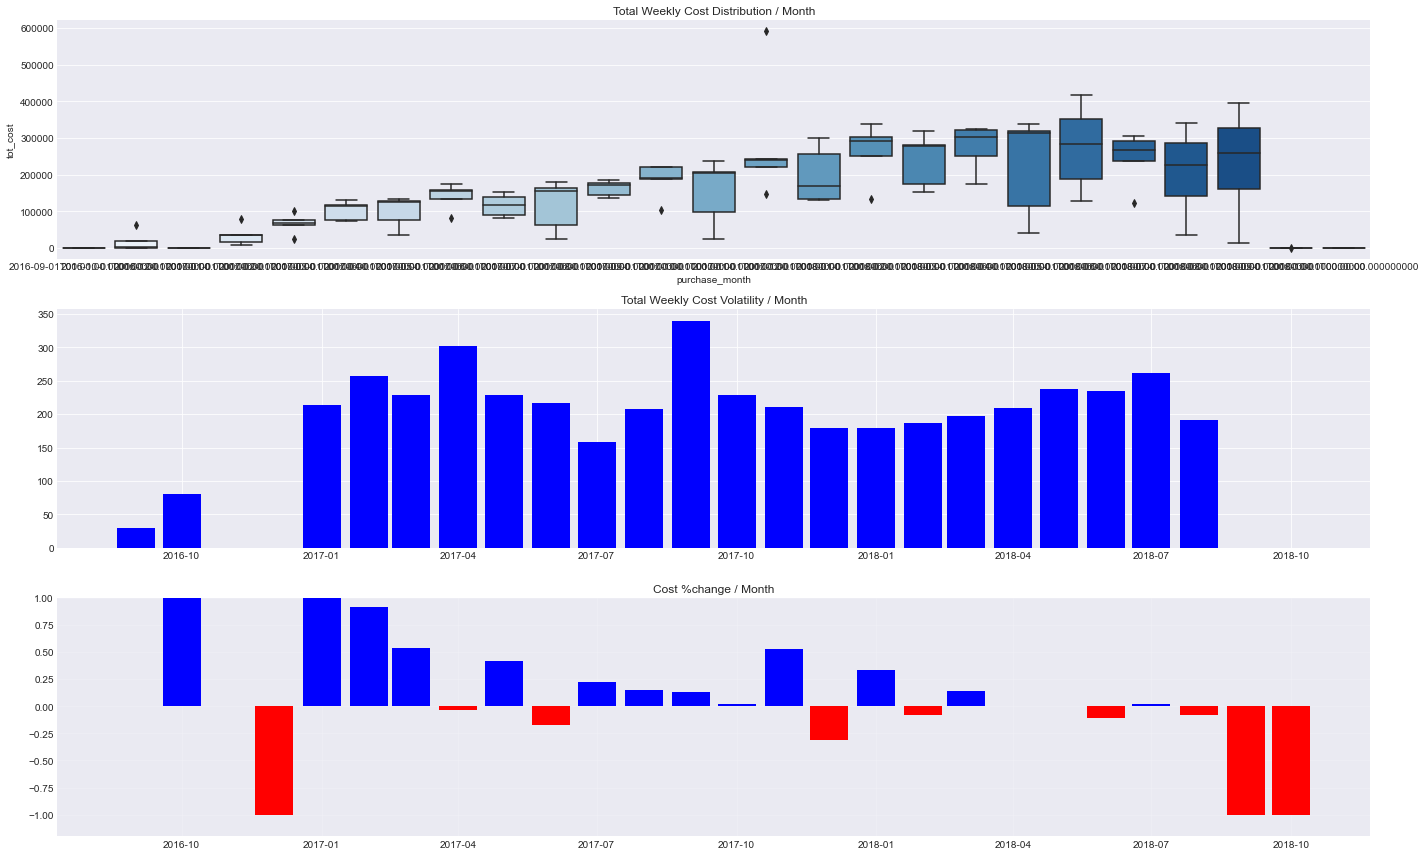

In [24]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))
data_graph = data.groupby(["purchase_month", "purchase_week"]).agg(tot_cost = ("total_order_value", sum), std_cost = ("total_order_value", "std")).fillna(0)
data_graph = data_graph.reset_index().drop("purchase_week", axis = 1)
sns.boxplot(x = "purchase_month", y = "tot_cost", data = data_graph, palette = "Blues", ax = ax[0])
data_graph = data_graph.groupby("purchase_month").agg({"tot_cost": sum, "std_cost": "mean"}).reset_index()
ax[1].bar(x = "purchase_month", height = "std_cost", data = data_graph, width = 25, color = "blue")
data_graph["tot_change"] = data_graph["tot_cost"].pct_change().fillna(0)
ax[2].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] >= 0], width = 25, color = "blue")
ax[2].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] < 0], width = 25, color = "red")
ax[0].set_title("Total Weekly Cost Distribution / Month")
ax[1].set_title("Total Weekly Cost Volatility / Month")
ax[2].set_title("Cost %change / Month")
ax[2].set_ylim(-1.2, 1)
ax[2].grid(alpha = 0.2)
plt.tight_layout()
plt.show()

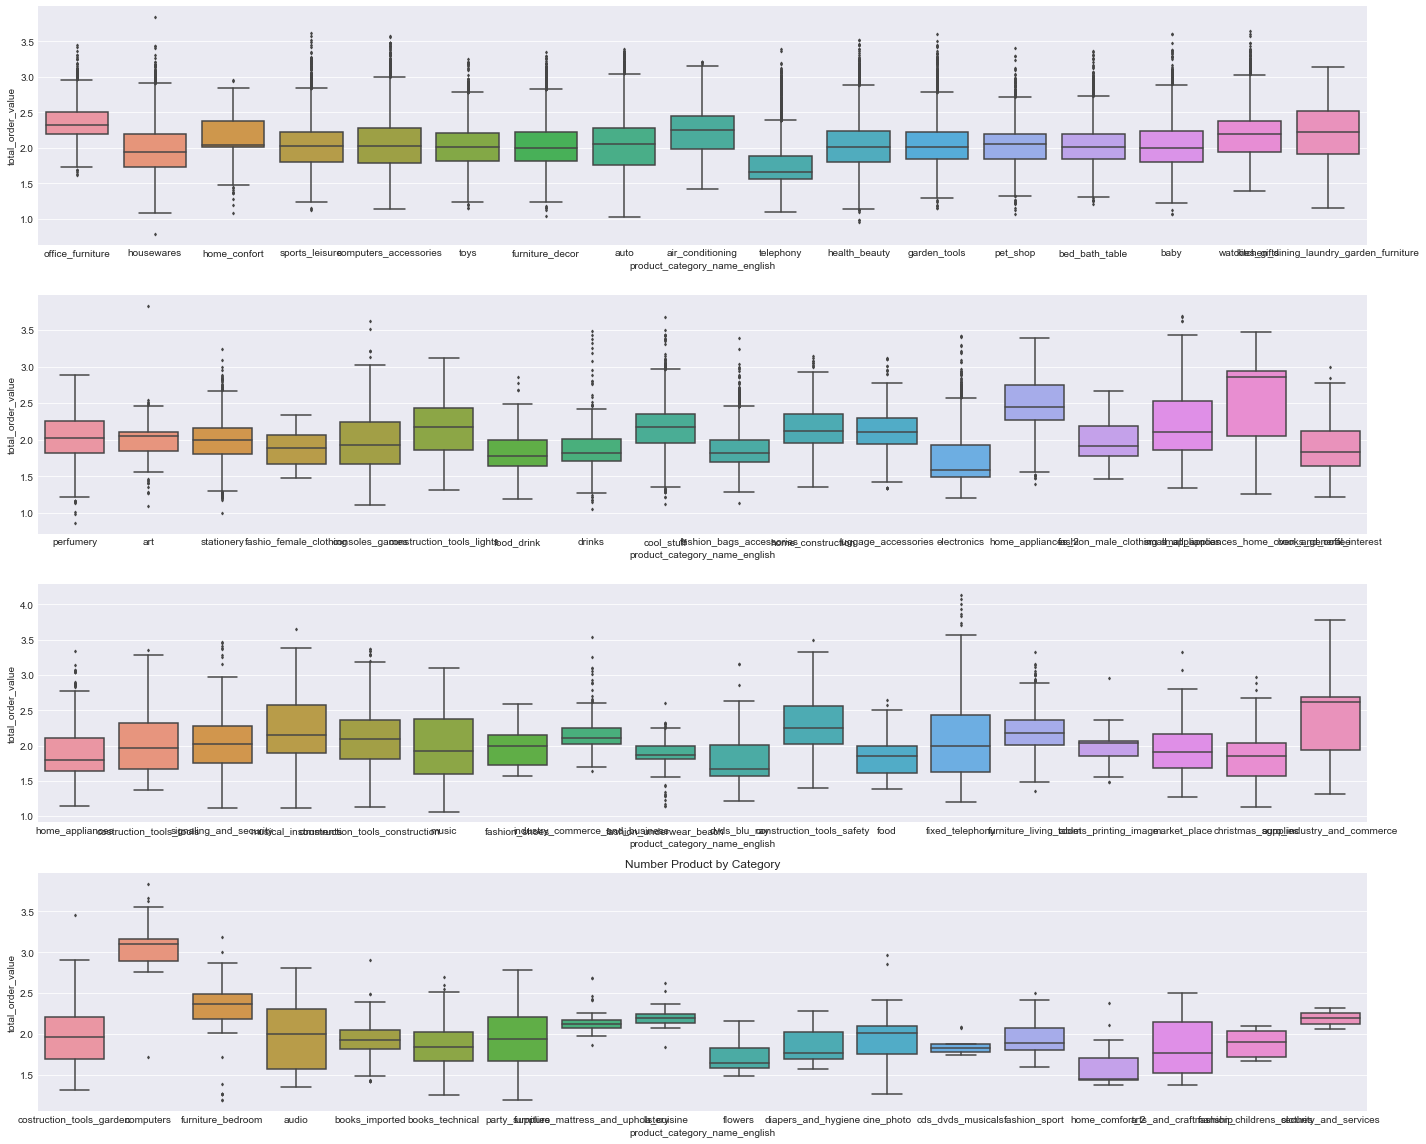

In [25]:
fig, ax = plt.subplots(4, 1, figsize = (20, 16))
types = data["product_category_name_english"].unique()
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["total_order_value"] != 0]["total_order_value"]), data = data[data["product_category_name_english"].isin(types[:18])], fliersize = 2, ax= ax[0])
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["total_order_value"] != 0]["total_order_value"]), data = data[data["product_category_name_english"].isin(types[18:36])], fliersize = 2, ax= ax[1])
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["total_order_value"] != 0]["total_order_value"]), data = data[data["product_category_name_english"].isin(types[36:54])], fliersize = 2, ax= ax[2])
sns.boxplot(x = "product_category_name_english", y = np.log10(data[data["total_order_value"] != 0]["total_order_value"]), data = data[data["product_category_name_english"].isin(types[54:72])], fliersize = 2, ax= ax[3])
plt.title("Number Product by Category")
plt.tight_layout()
plt.show()

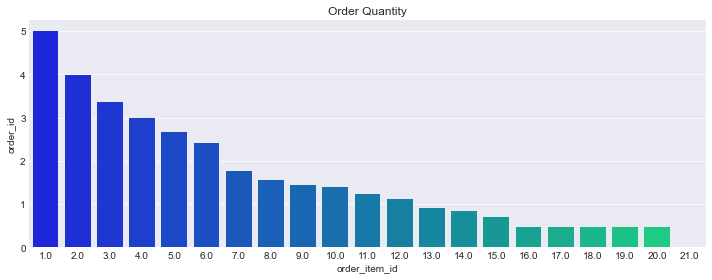

In [26]:
plt.figure(figsize = (10, 4))
data_graph = data.groupby("order_item_id").nunique()["order_id"].sort_values(ascending = False)
sns.barplot(x = data_graph.index, y = np.log10(data_graph), palette = "winter")
plt.title("Order Quantity")
plt.tight_layout()
plt.show()

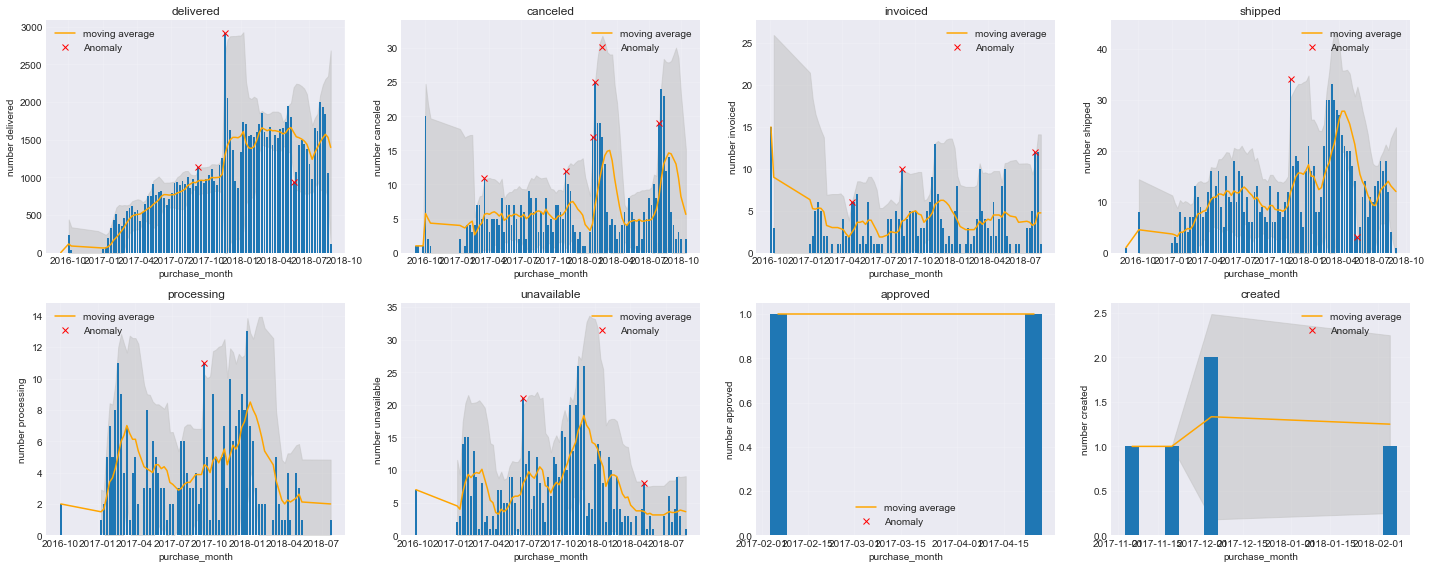

In [27]:
fig, ax = plt.subplots(2, 4, figsize = (20, 8))
status = data["order_status"].unique()
for row in range(2):
    for col in range(4):
        data_graph = pd.DataFrame(data[data["order_status"] == status[(row * 4) + col]].groupby("purchase_week").nunique()["order_id"])
        mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 8)
        ax[row, col].bar(data_graph.index, data_graph["order_id"], width = 5)
        ax[row, col].plot(mean.index, mean, color = "orange", label = "moving average")
        ax[row, col].fill_between(x = mean.index, y1 = lower_band["order_id"], y2 = upper_band["order_id"], color = "silver", alpha = 0.5)
        ax[row, col].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
        ax[row, col].grid(alpha = 0.2)
        ax[row, col].set_ylim(0)
        ax[row, col].legend()
        ax[row, col].set_title(status[(row * 4) + col])
        ax[row, col].set_xlabel(value[0])
        ax[row, col].set_ylabel(f"number {status[(row * 4) + col]}")
plt.tight_layout()
plt.show()

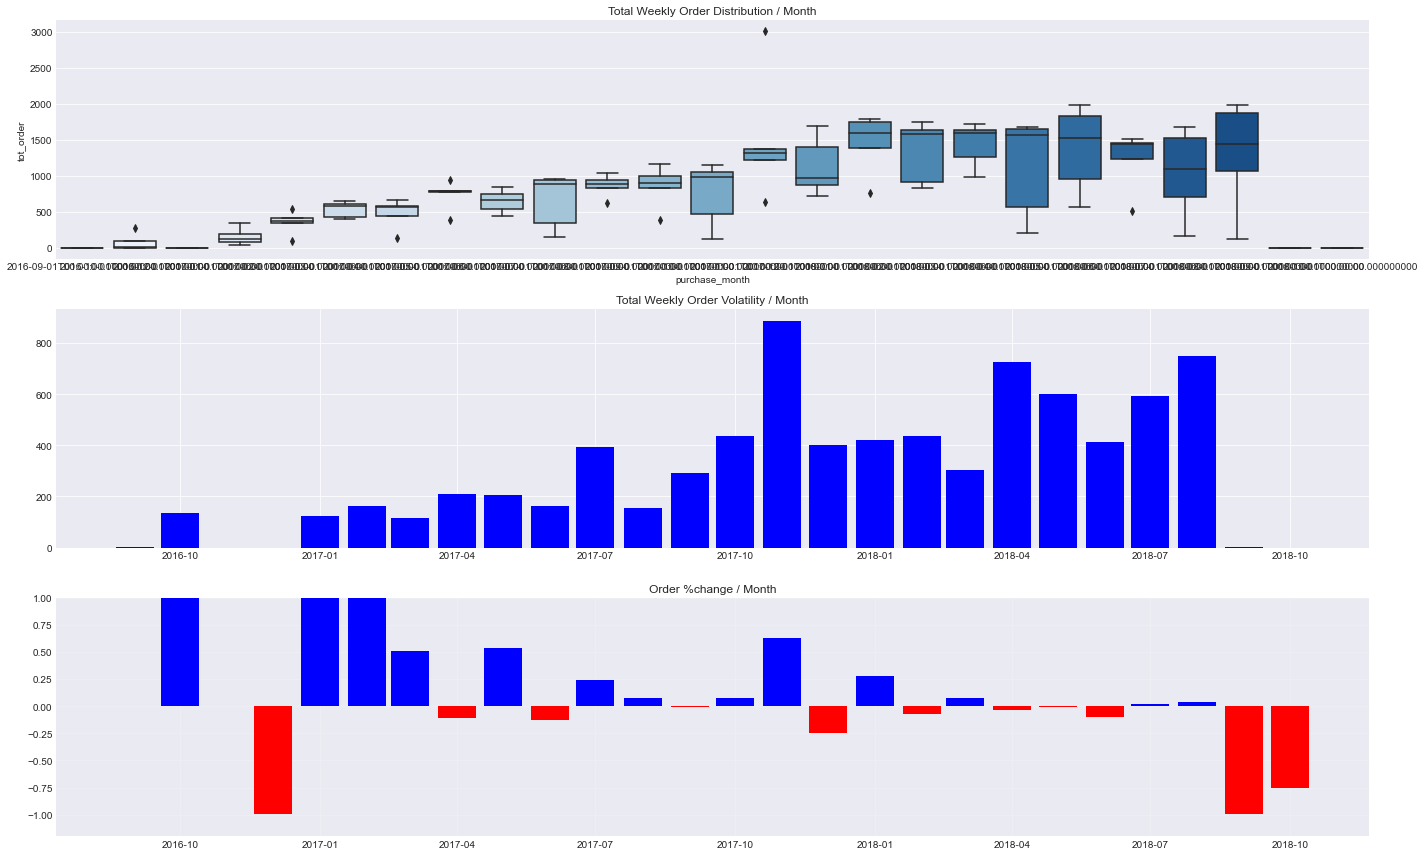

In [28]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))
data_graph = data.groupby(["purchase_month", "purchase_week"]).agg(tot_order = ("order_id", "nunique"), std_order = ("order_id", "nunique")).fillna(0)
data_graph = data_graph.reset_index().drop("purchase_week", axis = 1)
sns.boxplot(x = "purchase_month", y = "tot_order", data = data_graph, palette = "Blues", ax = ax[0])
data_graph = data_graph.groupby("purchase_month").agg({"tot_order": sum, "std_order": "std"}).reset_index()
ax[1].bar(x = "purchase_month", height = "std_order", data = data_graph, width = 25, color = "blue")
data_graph["tot_change"] = data_graph["tot_order"].pct_change().fillna(0)
ax[2].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] >= 0], width = 25, color = "blue")
ax[2].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] < 0], width = 25, color = "red")
ax[0].set_title("Total Weekly Order Distribution / Month")
ax[1].set_title("Total Weekly Order Volatility / Month")
ax[2].set_title("Order %change / Month")
ax[2].set_ylim(-1.2, 1)
ax[2].grid(alpha = 0.2)
plt.tight_layout()
plt.show()

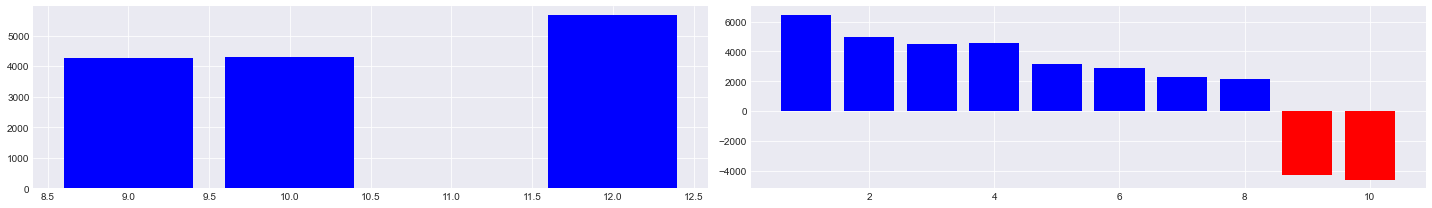

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (20, 3))
data_2016 = data[data["purchase_year"] == "2016"].groupby("purchase_month_num").nunique()["order_id"]
data_2017 = data[data["purchase_year"] == "2017"].groupby("purchase_month_num").nunique()["order_id"]
data_2018 = data[data["purchase_year"] == "2018"].groupby("purchase_month_num").nunique()["order_id"]
diff_1617 = data_2017 - data_2016
diff_1718 = data_2018 - data_2017
ax[0].bar(diff_1617[diff_1617 >= 0].index, diff_1617[diff_1617 >= 0], color = "blue")
ax[0].bar(diff_1617[diff_1617 < 0].index, diff_1617[diff_1617 < 0], color = "red")
ax[1].bar(diff_1718[diff_1718 >= 0].index, diff_1718[diff_1718 >= 0], color = "blue")
ax[1].bar(diff_1718[diff_1718 < 0].index, diff_1718[diff_1718 < 0], color = "red")
plt.tight_layout()
plt.show()

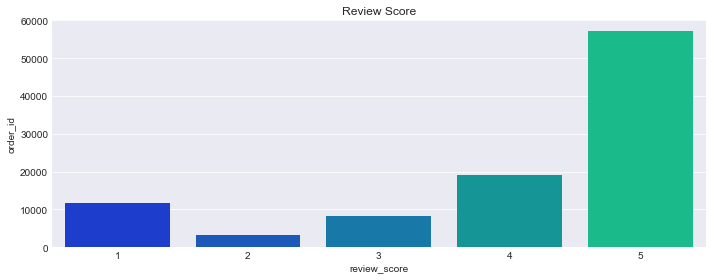

In [30]:
plt.figure(figsize = (10, 4))
data_graph = data.groupby("review_score").nunique()["order_id"].sort_values(ascending = False)
sns.barplot(x = data_graph.index, y = data_graph, palette = "winter")
plt.title("Review Score")
plt.tight_layout()
plt.show()

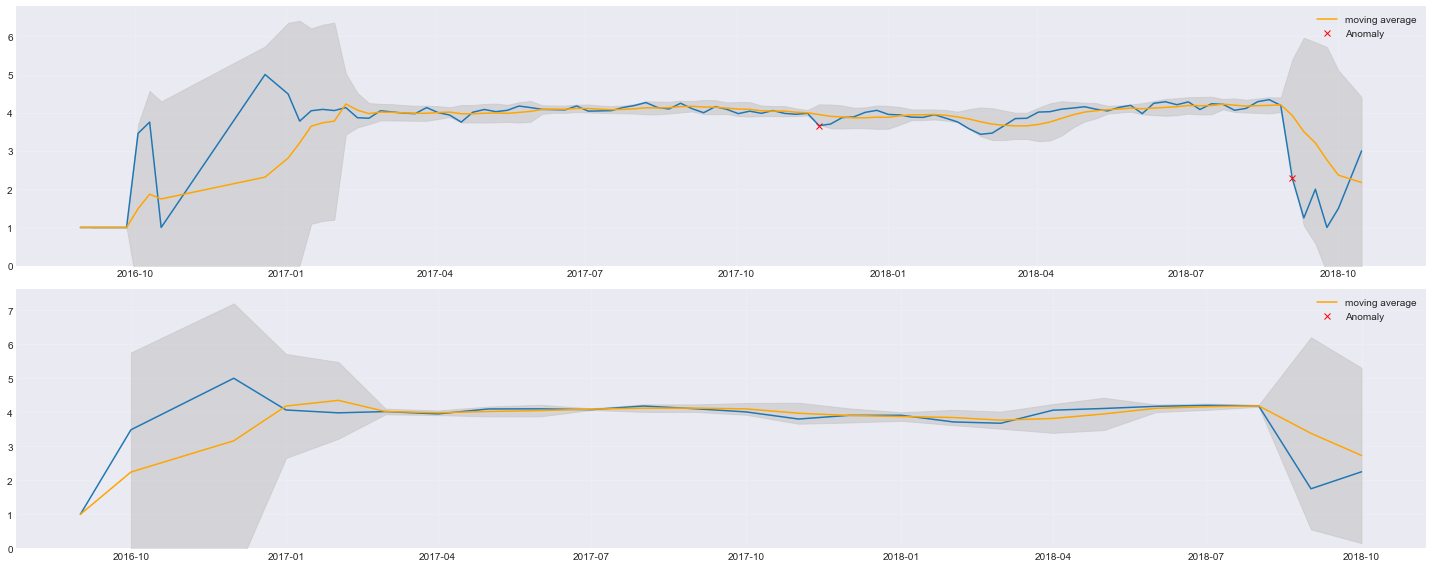

In [31]:
fig, ax = plt.subplots(2, 1, figsize = (20, 8))
features = {0: ["purchase_week", 7, 0.8], 1: ["purchase_month", 3, 20]}
for key, value in features.items():
    data_graph = pd.DataFrame(data.groupby(value[0]).mean()["review_score"])
    mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
    ax[key].plot(data_graph.index, data_graph)
    ax[key].plot(mean.index, mean, color = "orange", label = "moving average")
    ax[key].fill_between(x = mean.index, y1 = lower_band["review_score"], y2 = upper_band["review_score"], color = "silver", alpha = 0.5)
    ax[key].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
    ax[key].grid(alpha = 0.2)
    ax[key].set_ylim(0)
    ax[key].legend()
#         ax[key].set_title(status[(row * 4) + col])
#         ax[key].set_xlabel(value[0])
#         ax[key].set_ylabel(f"number {status[(row * 4) + col]}")
plt.tight_layout()
plt.show()

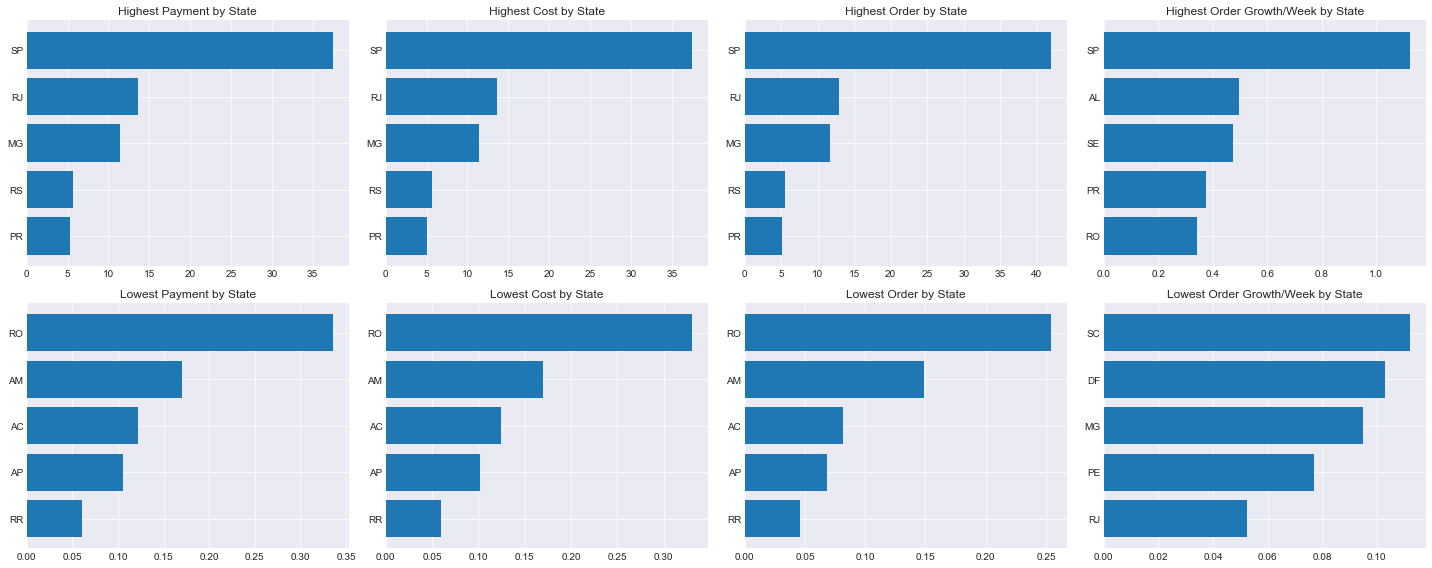

In [32]:
fig, ax = plt.subplots(2, 4, figsize = (20, 8))
data_graph = data.groupby("customer_state").sum()["payment_value"].sort_values() / data["payment_value"].sum() * 100
ax[0, 0].barh(data_graph.tail(5).index, data_graph.tail(5))
ax[1, 0].barh(data_graph.head(5).index, data_graph.head(5))
ax[0, 0].set_title("Highest Payment by State")
ax[1, 0].set_title("Lowest Payment by State")
data_graph = data.groupby("customer_state").sum()["total_order_value"].sort_values() / data["total_order_value"].sum() * 100
ax[0, 1].barh(data_graph.tail(5).index, data_graph.tail(5))
ax[1, 1].barh(data_graph.head(5).index, data_graph.head(5))
ax[0, 1].set_title("Highest Cost by State")
ax[1, 1].set_title("Lowest Cost by State")
data_graph = data.groupby("customer_state").nunique()["order_id"].sort_values() / data["order_id"].nunique() * 100
ax[0, 2].barh(data_graph.tail(5).index, data_graph.tail(5))
ax[1, 2].barh(data_graph.head(5).index, data_graph.head(5))
ax[0, 2].set_title("Highest Order by State")
ax[1, 2].set_title("Lowest Order by State")

state_growth = {}
for state in data["customer_state"].unique():
    data_graph = pd.DataFrame(data[data["customer_state"] == state].groupby("purchase_week").nunique()["order_id"])
    data_graph["growth"] = data_graph.pct_change().fillna(0)
    state_growth[state] = data_graph["growth"].mean()
data_graph = pd.DataFrame(state_growth.values(), index = state_growth.keys()).rename(columns = {0: "growth"})
data_graph = data_graph.sort_values("growth")
ax[0, 3].barh(data_graph.tail(5).index, data_graph["growth"].tail(5))
ax[1, 3].barh(data_graph.head(5).index, data_graph["growth"].head(5))
ax[0, 3].set_title("Highest Order Growth/Week by State")
ax[1, 3].set_title("Lowest Order Growth/Week by State")
plt.tight_layout()
plt.show()

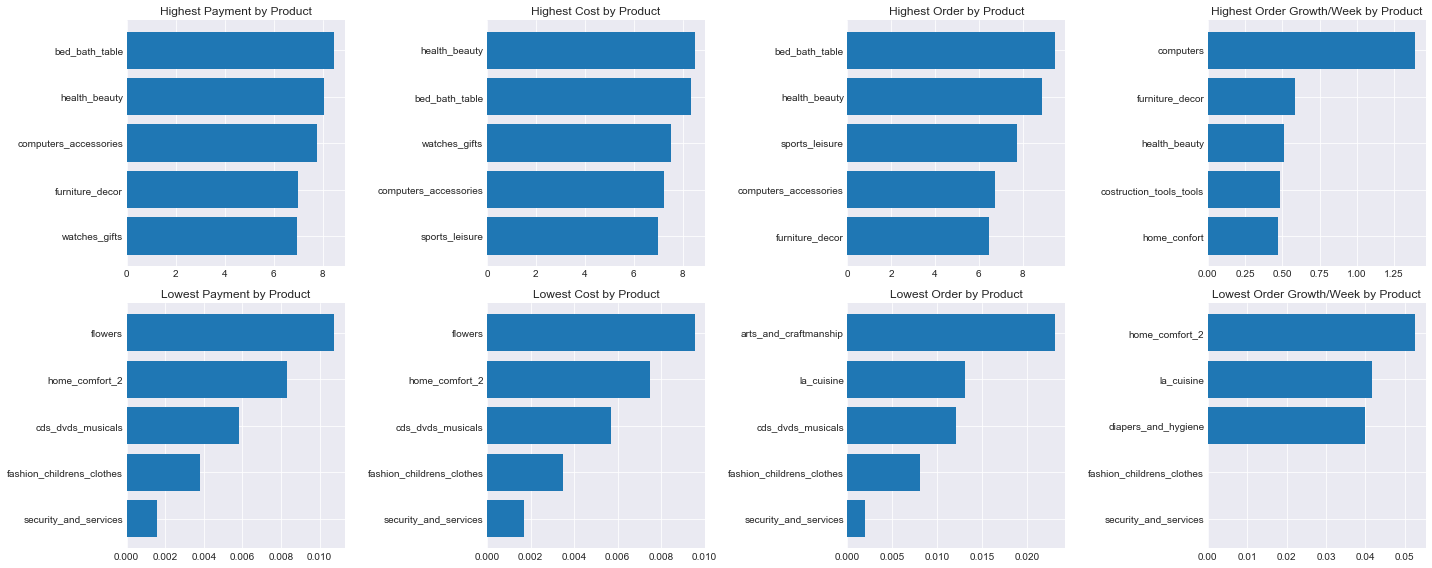

In [33]:
fig, ax = plt.subplots(2, 4, figsize = (20, 8))
data_graph = data.groupby("product_category_name_english").sum()["payment_value"].sort_values() / data["payment_value"].sum() * 100
ax[0, 0].barh(data_graph.tail(5).index, data_graph.tail(5))
ax[1, 0].barh(data_graph.head(5).index, data_graph.head(5))
ax[0, 0].set_title("Highest Payment by Product")
ax[1, 0].set_title("Lowest Payment by Product")
data_graph = data.groupby("product_category_name_english").sum()["total_order_value"].sort_values() / data["total_order_value"].sum() * 100
ax[0, 1].barh(data_graph.tail(5).index, data_graph.tail(5))
ax[1, 1].barh(data_graph.head(5).index, data_graph.head(5))
ax[0, 1].set_title("Highest Cost by Product")
ax[1, 1].set_title("Lowest Cost by Product")
data_graph = data.groupby("product_category_name_english").nunique()["order_id"].sort_values() / data["order_id"].nunique() * 100
ax[0, 2].barh(data_graph.tail(5).index, data_graph.tail(5))
ax[1, 2].barh(data_graph.head(5).index, data_graph.head(5))
ax[0, 2].set_title("Highest Order by Product")
ax[1, 2].set_title("Lowest Order by Product")

state_growth = {}
for state in data["product_category_name_english"].unique():
    data_graph = pd.DataFrame(data[data["product_category_name_english"] == state].groupby("purchase_week").nunique()["order_id"])
    data_graph["growth"] = data_graph.pct_change().fillna(0)
    state_growth[state] = data_graph["growth"].mean()
data_graph = pd.DataFrame(state_growth.values(), index = state_growth.keys()).rename(columns = {0: "growth"})
data_graph = data_graph.sort_values("growth").dropna()
ax[0, 3].barh(data_graph.tail(5).index, data_graph["growth"].tail(5))
ax[1, 3].barh(data_graph.head(5).index, data_graph["growth"].head(5))
ax[0, 3].set_title("Highest Order Growth/Week by Product")
ax[1, 3].set_title("Lowest Order Growth/Week by Product")
plt.tight_layout()
plt.show()

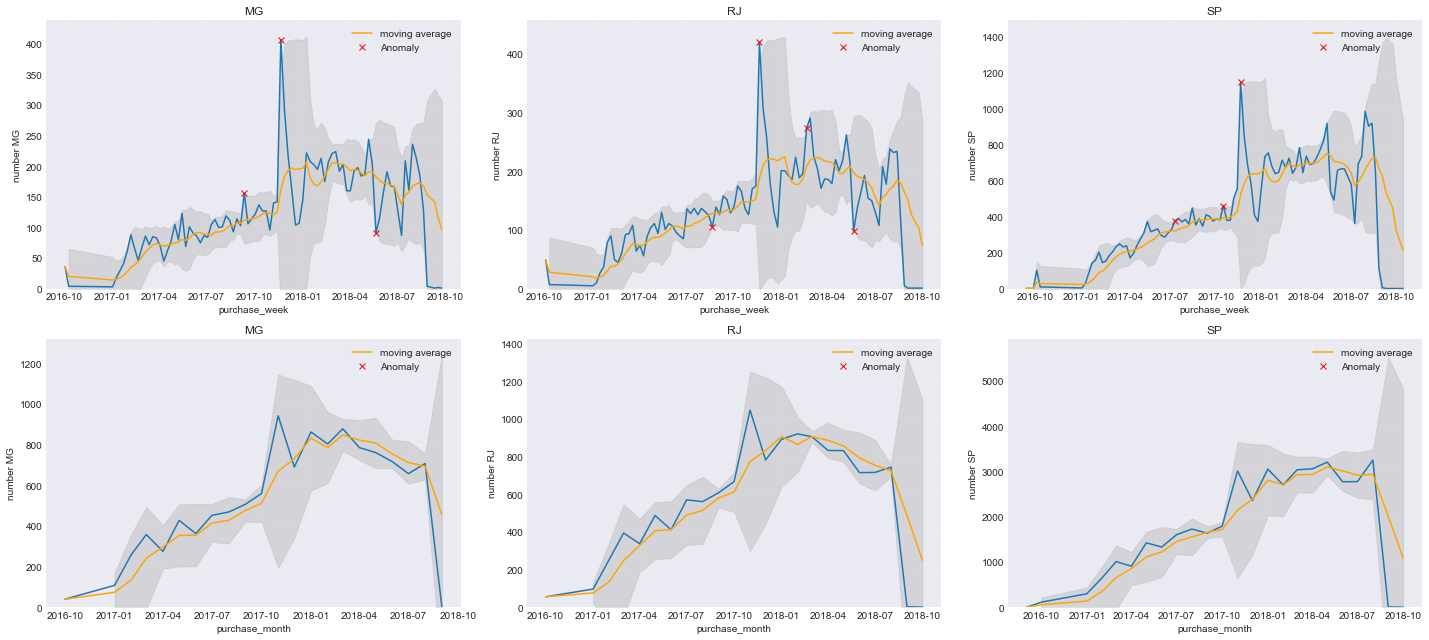

In [34]:
fig, ax = plt.subplots(2, 3, figsize = (20, 9))

columns = data.groupby("customer_state").sum()["payment_value"].sort_values().tail(3).index
features = {0: ["purchase_week", 8], 1: ["purchase_month", 3]}
for column in range(len(columns)):
    for key, value in features.items():
        data_graph = pd.DataFrame(data[data["customer_state"] == columns[column]].groupby(value[0]).nunique()["order_id"])
        mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
        ax[key, column].plot(data_graph.index, data_graph)
        ax[key, column].plot(mean.index, mean, color = "orange", label = "moving average")
        ax[key, column].fill_between(x = mean.index, y1 = lower_band["order_id"], y2 = upper_band["order_id"], color = "silver", alpha = 0.5)
        ax[key, column].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
        ax[key, column].grid(alpha = 0.2)
        ax[key, column].set_ylim(0)
        ax[key, column].legend()
        ax[key, column].set_title(columns[column])
        ax[key, column].set_xlabel(value[0])
        ax[key, column].set_ylabel(f"number {columns[column]}")
plt.tight_layout()
plt.show()

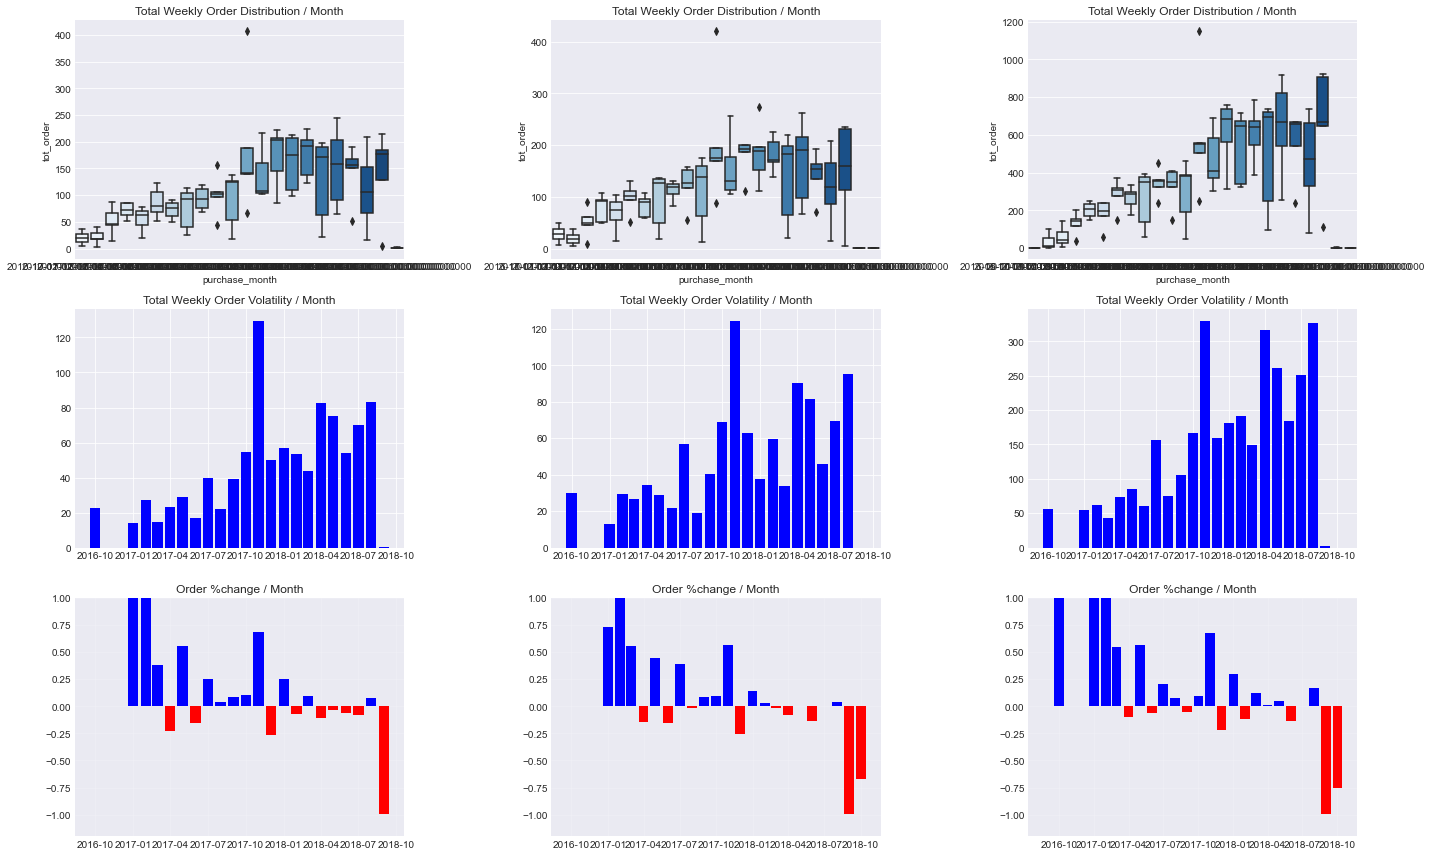

In [35]:
fig, ax = plt.subplots(3, 3, figsize = (20, 12))
states = data.groupby("customer_state").sum()["payment_value"].sort_values().tail(3).index
for state in range(len(states)):
    data_graph = data[data["customer_state"] == states[state]].groupby(["purchase_month", "purchase_week"]).agg(tot_order = ("order_id", "nunique"), std_order = ("order_id", "nunique")).fillna(0)
    data_graph = data_graph.reset_index().drop("purchase_week", axis = 1)
    sns.boxplot(x = "purchase_month", y = "tot_order", data = data_graph, palette = "Blues", ax = ax[0, state])
    data_graph = data_graph.groupby("purchase_month").agg({"tot_order": sum, "std_order": "std"}).reset_index()
    ax[1, state].bar(x = "purchase_month", height = "std_order", data = data_graph, width = 25, color = "blue")
    data_graph["tot_change"] = data_graph["tot_order"].pct_change().fillna(0)
    ax[2, state].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] >= 0], width = 25, color = "blue")
    ax[2, state].bar(x = "purchase_month", height = "tot_change", data = data_graph[data_graph["tot_change"] < 0], width = 25, color = "red")
    ax[0, state].set_title("Total Weekly Order Distribution / Month")
    ax[1, state].set_title("Total Weekly Order Volatility / Month")
    ax[2, state].set_title("Order %change / Month")
    ax[2, state].set_ylim(-1.2, 1)
    ax[2, state].grid(alpha = 0.2)
plt.tight_layout()
plt.show()

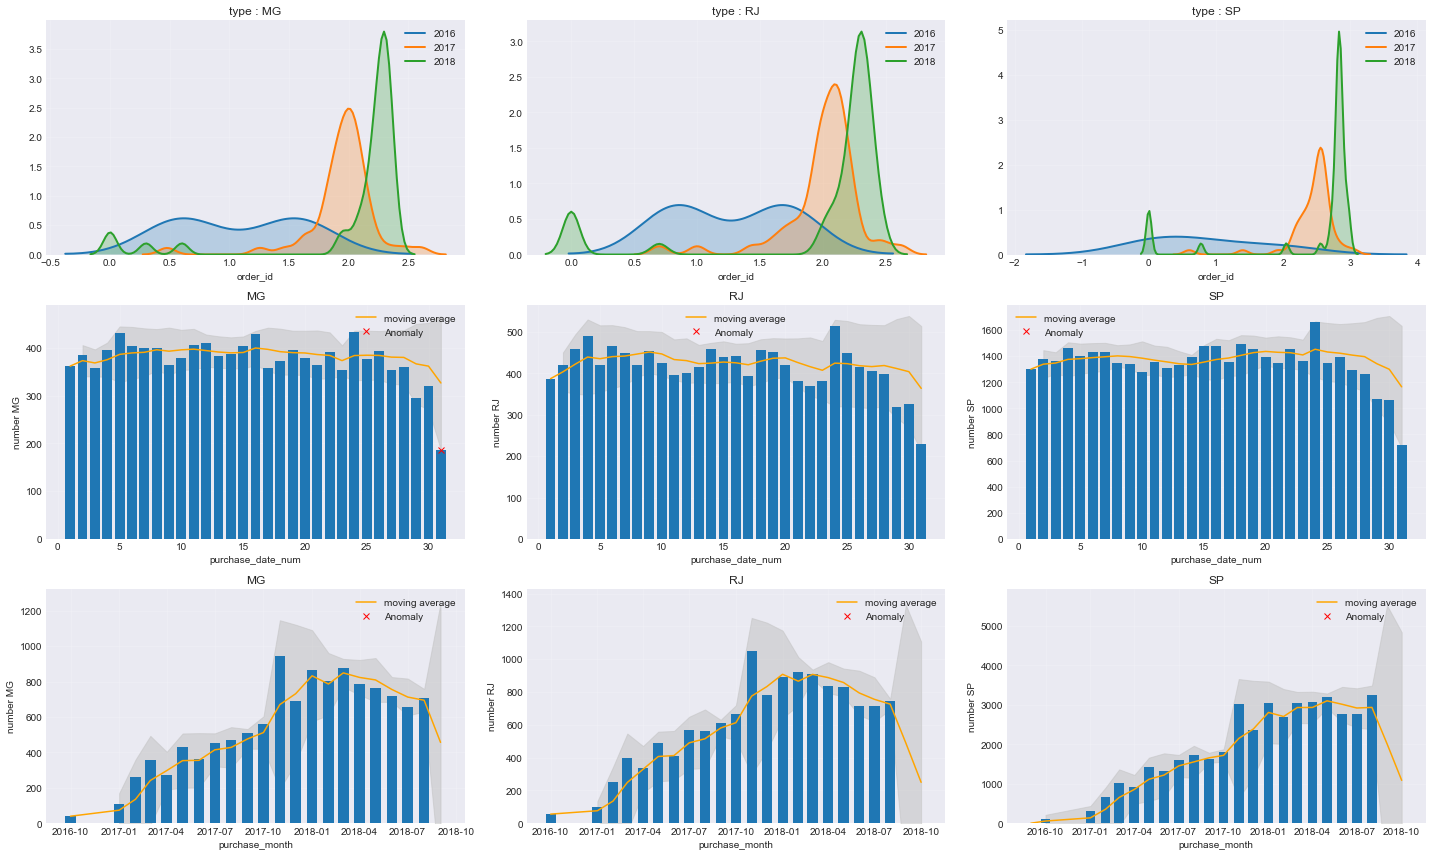

In [36]:
fig, ax = plt.subplots(3, 3, figsize = (20, 12))
types = data.groupby("customer_state").sum()["payment_value"].sort_values().tail(3).index
for pt in range(len(types)):
    for year in range(3):
        sns.distplot(np.log10(data[(data["customer_state"] == types[pt]) & (data["purchase_year"] == str(2016 + year))].groupby(["purchase_week"]).nunique()["order_id"]),
                     hist = False, kde_kws = {'shade': True, 'linewidth': 2}, label = str(2016 + year), ax = ax[0, pt])
    ax[0, pt].set_title(f"type : {types[pt]}")
    ax[0, pt].grid(alpha = 0.2)

features = {0: ["purchase_date_num", 7, 0.8], 1: ["purchase_month", 3, 20]}
for column in range(len(types)):
    for key, value in features.items():
        data_graph = pd.DataFrame(data[data["customer_state"] == types[column]].groupby(value[0]).nunique()["order_id"])
        mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = value[1])
        ax[key + 1, column].bar(data_graph.index, data_graph["order_id"], width = value[2])
        ax[key + 1, column].plot(mean.index, mean, color = "orange", label = "moving average")
        ax[key + 1, column].fill_between(x = mean.index, y1 = lower_band["order_id"], y2 = upper_band["order_id"], color = "silver", alpha = 0.5)
        ax[key + 1, column].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
        ax[key + 1, column].grid(alpha = 0.2)
        ax[key + 1, column].set_ylim(0)
        ax[key + 1, column].legend()
        ax[key + 1, column].set_title(types[column])
        ax[key + 1, column].set_xlabel(value[0])
        ax[key + 1, column].set_ylabel(f"number {types[column]}")
plt.tight_layout()
plt.show()

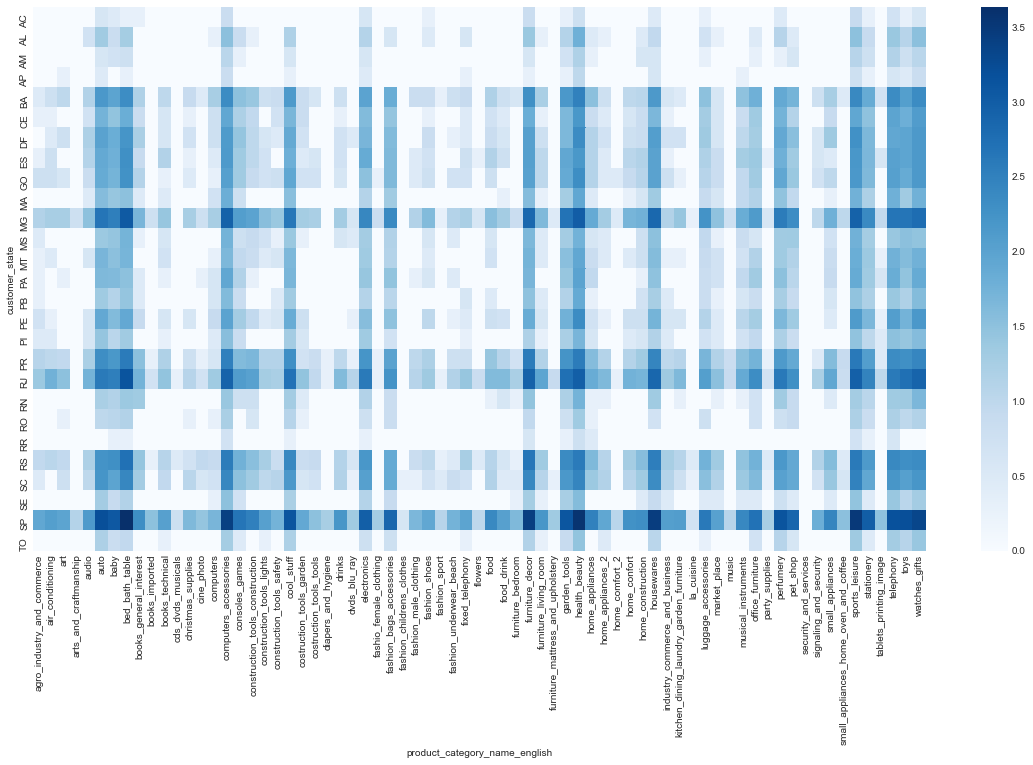

In [37]:
plt.figure(figsize = (20, 10))
data_graph = data.groupby(["customer_state", "product_category_name_english"]).nunique()["customer_unique_id"]
data_graph = np.log10(data_graph).reset_index()
data_graph = data_graph.pivot_table(values = "customer_unique_id", index = "customer_state", columns = "product_category_name_english").fillna(0)
sns.heatmap(data_graph, cmap = "Blues")
plt.show()

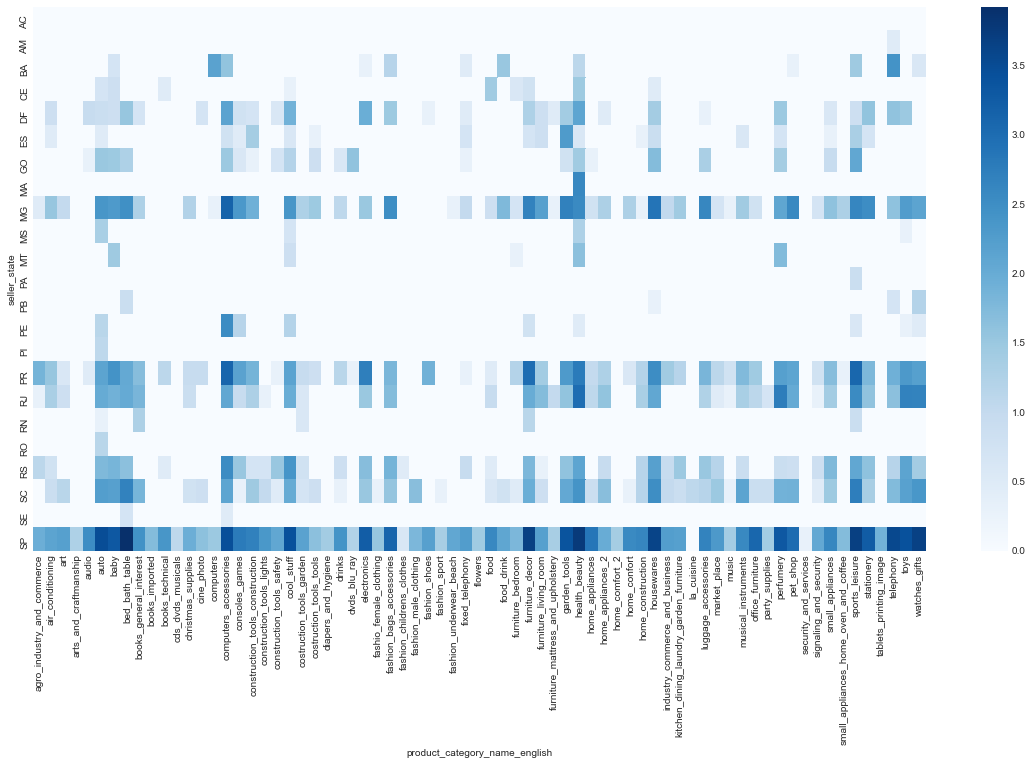

In [38]:
plt.figure(figsize = (20, 10))
data_graph = data.groupby(["seller_state", "product_category_name_english"]).nunique()["order_id"]
data_graph = np.log10(data_graph).reset_index()
data_graph = data_graph.pivot_table(values = "order_id", index = "seller_state", columns = "product_category_name_english").fillna(0)
sns.heatmap(data_graph, cmap = "Blues")
plt.show()

In [39]:
columns = data.groupby("product_category_name_english").nunique()["order_id"].sort_values().tail(5).index
data_graph = data[data["product_category_name_english"].isin(columns)].groupby(["seller_state", "product_category_name_english"]).nunique()["order_id"]
data_ord_sell = np.log10(data_graph).reset_index()
data_graph = data[data["product_category_name_english"].isin(columns)].groupby(["customer_state", "product_category_name_english"]).nunique()["order_id"]
data_ord_cust = np.log10(data_graph).reset_index()
data_graph = pd.merge(data_ord_cust, data_ord_sell, how = "left", left_on = ["customer_state", "product_category_name_english"], right_on = ["seller_state", "product_category_name_english"]).fillna(0)
data_graph = data_graph.rename(columns = {"order_id_x": "customer", "order_id_y": "seller"})
data_graph = data_graph.drop("seller_state", axis = 1)

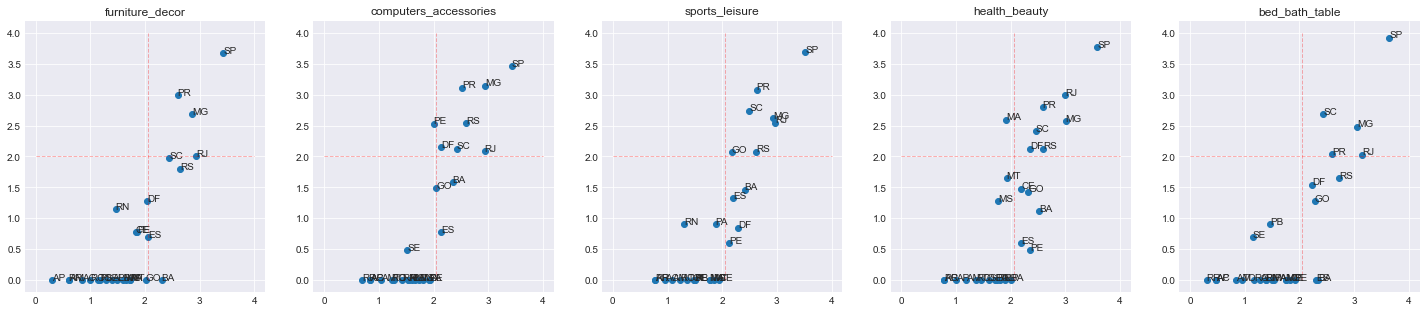

In [40]:
fig, ax = plt.subplots(1, 5, figsize = (25, 5))
columns = data.groupby("product_category_name_english").nunique()["order_id"].sort_values().tail(5).index
for col in range(len(columns)):
    ax[col].scatter(data_graph[data_graph["product_category_name_english"] == columns[col]]["customer"],
                  data_graph[data_graph["product_category_name_english"] == columns[col]]["seller"])
    ax[col].plot([2.05, 2.05], [0, 4], lw = 1, ls = "--", color = "red", alpha = 0.3)
    ax[col].plot([0, 4], [2, 2], lw = 1, ls = "--", color = "red", alpha = 0.3)
    ax[col].set_title(columns[col])
    for i, txt in enumerate(data_graph["customer_state"].unique()):
        ax[col].annotate(txt, (data_graph[data_graph["product_category_name_english"] == columns[col]].reset_index()["customer"][i],
                               data_graph[data_graph["product_category_name_english"] == columns[col]].reset_index()["seller"][i]))

In [41]:
data_graph = data.groupby("customer_unique_id").agg(tot_pay = ("payment_value", "sum"),
                                                    avg_pay = ("payment_value", "mean"),
                                                    tot_cost = ("total_order_value", "sum"),
                                                    avg_cost = ("total_order_value", "mean"),
                                                    num_week = ("purchase_week", "nunique"),
                                                    num_order = ("order_id", "nunique"),
                                                    review = ("review_score", "mean"),
                                                    state = ("customer_state", max)).sort_values("num_week", ascending = False)
data_graph["tot_profit"] = data_graph["tot_pay"] - data_graph["tot_cost"]
data_graph["profit/order"] = data_graph["tot_profit"] / data_graph["num_order"]

In [42]:
data_graph

,tot_pay,avg_pay,tot_cost,avg_cost,num_week,num_order,review,state,tot_profit,profit/order
customer_unique_id,,,,,,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,927.63,54.566471,902.04,56.377500,15,17,4.764706,SP,25.59,1.505294
ca77025e7201e3b30c44b472ff346268,2126.44,177.203333,1624.58,135.381667,7,7,5.000000,PE,501.86,71.694286
1b6c7548a2a1f9037c1fd3ddfed95f33,1386.54,138.654000,1260.04,126.004000,6,7,5.000000,MG,126.50,18.071429
6469f99c1f9dfae7733b25662e7f1782,973.09,108.121111,824.04,91.560000,6,7,5.000000,SP,149.05,21.292857
3e43e6105506432c953e165fb2acf44c,1963.58,140.255714,1506.37,107.597857,6,9,2.642857,SP,457.21,50.801111
...,...,...,...,...,...,...,...,...,...,...
55fce1ba5ed536b6b60c5b799815f45c,111.35,111.350000,111.35,111.350000,1,1,5.000000,SP,0.00,0.000000
55fcb2a02e244d1f0de2c490cb9f5a18,90.44,90.440000,90.44,90.440000,1,1,1.000000,MS,0.00,0.000000
55fc3a9e868992d2d339316d0800ecd2,1405.44,351.360000,878.40,219.600000,1,1,4.000000,PE,527.04,527.040000


Most of the purchase occurs around 10AM - 3PM. This is the best time to advertise our product.

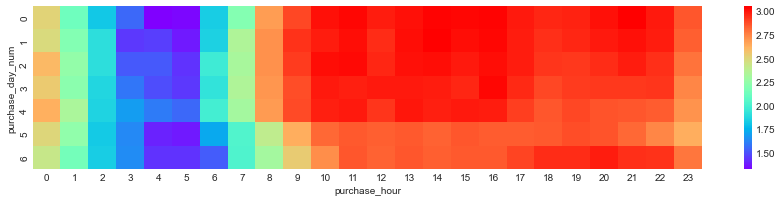

In [43]:
data_graph= pd.DataFrame(np.log10(data.sort_values(["purchase_day_num", "purchase_hour"]).groupby(["purchase_day_num", "purchase_hour"]).nunique()["order_id"]))
data_graph = data_graph.pivot_table(values = "order_id", index = "purchase_day_num", columns = "purchase_hour").fillna(0)
plt.figure(figsize = (15, 3))
sns.heatmap(data_graph, cmap = "rainbow")
plt.show()

In [44]:
new_df = data.copy() #"order_status",product category name
dum_order = pd.get_dummies(new_df["order_status"], drop_first = True)
dum_prdct = pd.get_dummies(new_df["product_category_name"], drop_first = True)
new_df = pd.concat([new_df, dum_order, dum_prdct], axis = 1)
new_df = new_df.drop(["order_status", "product_category_name"], axis = 1)
new_df = pd.merge(new_df.groupby("customer_state").agg({"customer_unique_id": "nunique", "customer_city": "nunique", "order_id": "nunique", "seller_id": "nunique",
                                               "delivery_day": "median", "total_order_value": "median", "product_volume": "median",
                                               "review_score": "mean"}).reset_index(),
                  new_df.groupby("customer_state").sum().iloc[:, -79:].reset_index(), on = "customer_state")

In [45]:
from sklearn.cluster import KMeans

In [46]:
km = KMeans(n_clusters = 5)
km.fit(new_df.drop("customer_state", axis = 1))
new_df["cluster"] = km.predict(new_df.drop("customer_state", axis = 1))

In [47]:
state_growth = {}
for state in data["customer_state"].unique():
    data_graph = pd.DataFrame(data[data["customer_state"] == state].groupby("purchase_week").agg(med_payment = ("payment_value", "median"),
                                                                                                 total_payment = ("payment_value", sum),
                                                                                                 num_city = ("customer_city", "nunique"),
                                                                                                 num_ord = ("order_id", "nunique")))
    data_graph["ord_growth"] = data_graph["num_ord"].pct_change().fillna(0)
    data_graph["payment/city"] = data_graph["med_payment"] / data_graph["num_city"]
    state_growth[state] = data_graph.mean()
data_graph = pd.DataFrame(state_growth.values(), index = state_growth.keys()).rename(columns = {0: "growth"})
data_graph = data_graph.sort_values("ord_growth")

In [48]:
data_graph = pd.concat([data_graph, new_df.set_index("customer_state")["cluster"]], axis = 1)

In [49]:
data_graph = data_graph.sort_index()

By growth, SP still the best palce to invest. SP have the highest growth and can become the revenue contributor for the e-commerce. Also we can learn why this region can have the highest growth, if that possible if we use the marketing strategy in this area to get more customers in other area.

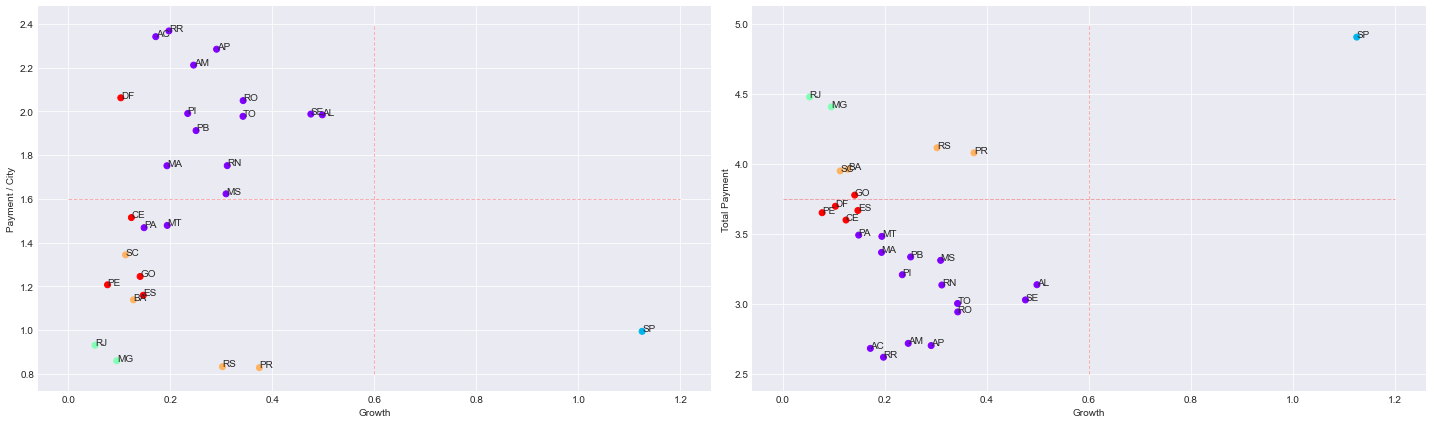

In [94]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ax[0].scatter(data_graph["ord_growth"], np.log10(data_graph["payment/city"]), c = new_df["cluster"], cmap = "rainbow")
ax[0].set_xlabel("Growth")
ax[0].set_ylabel("Payment / City")
ax[0].plot([0.6, 0.6], [0.8, 2.4], lw = 1, ls = "--", color = "red", alpha = 0.3)
ax[0].plot([0, 1.2], [1.6, 1.6], lw = 1, ls = "--", color = "red", alpha = 0.3)
for i, txt in enumerate(data_graph.index):
    ax[0].annotate(txt, (data_graph.reset_index()["ord_growth"][i], np.log10(data_graph.reset_index()["payment/city"][i])))
ax[1].scatter(data_graph["ord_growth"], np.log10(data_graph["total_payment"]), c = new_df["cluster"], cmap = "rainbow")
ax[1].set_xlabel("Growth")
ax[1].set_ylabel("Total Payment")
ax[1].plot([0.6, 0.6], [2.5, 5], lw = 1, ls = "--", color = "red", alpha = 0.3)
ax[1].plot([0, 1.2], [3.75, 3.75], lw = 1, ls = "--", color = "red", alpha = 0.3)
for i, txt in enumerate(data_graph.index):
    ax[1].annotate(txt, (data_graph.reset_index()["ord_growth"][i], np.log10(data_graph.reset_index()["total_payment"][i])))
plt.tight_layout()
plt.show()
fig.savefig('data_brazil_ecommerce.png')

---
## **2. Time Series - Order Forecast**
---

In [51]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [52]:
ts_pred = data.copy()
ts_pred = ts_pred.groupby("purchase_date").nunique()
ts_pred["next"] = ts_pred["order_id"].shift()
ts_pred = ts_pred.dropna()

In [53]:
X = ts_pred["order_id"].values
y = ts_pred["next"].values

In [54]:
train_size = int(len(X) * 0.8)

In [55]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [56]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [59]:
lr.coef_

array([0.78679453])

In [60]:
y_pred = lr.predict(X_test)

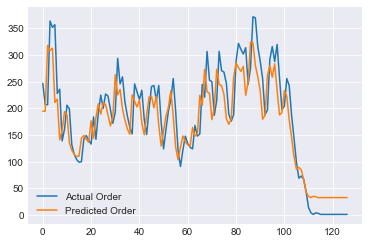

In [61]:
plt.plot(y_test[-127:], label = "Actual Order")
plt.plot(y_pred[-127:], label = "Predicted Order")
plt.legend()
plt.show()

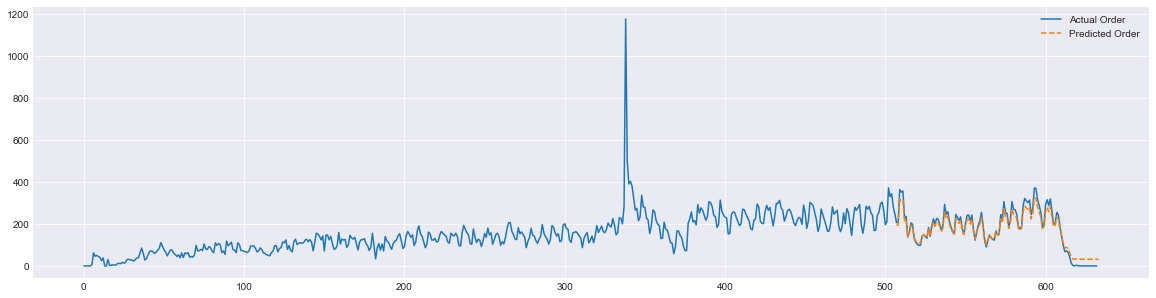

In [62]:
plt.figure(figsize = (20, 5))
plt.plot(np.append(y_train, y_test), label = "Actual Order")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Predicted Order")
plt.legend()
plt.show()

In [63]:
model = ARIMA(y_test, order = (1, 1, 1))

In [64]:
model_fit = model.fit(disp = 5)

In [65]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  126
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -651.968
Method:                       css-mle   S.D. of innovations             42.732
Date:                Mon, 07 Sep 2020   AIC                           1311.935
Time:                        20:17:36   BIC                           1323.280
Sample:                             1   HQIC                          1316.544
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9891      2.118     -0.939      0.348      -6.140       2.162
ar.L1.D.y      0.6844      0.169      4.038      0.000       0.352       1.017
ma.L1.D.y     -0.8284      0.128     -6.487      0.0

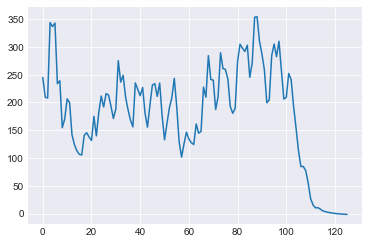

In [66]:
predictions = model_fit.predict(exog = X_test, typ = "levels")
plt.plot(predictions)

In [67]:
len(predictions)

126

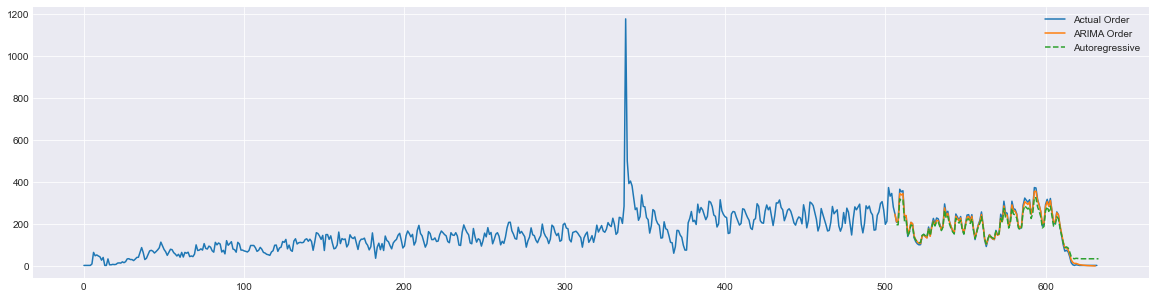

In [68]:
plt.figure(figsize = (20, 5))
plt.plot(np.append(y_train, y_test), label = "Actual Order")
plt.plot(np.append(np.array([None] * len(y_train)), predictions), label = "ARIMA Order")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Autoregressive")
plt.legend()
plt.show()

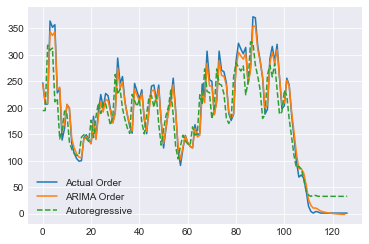

In [69]:
plt.plot(y_test, label = "Actual Order")
plt.plot(predictions, label = "ARIMA Order")
plt.plot(y_pred, "--", label = "Autoregressive")
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error

In [71]:
mean_squared_error(y_test, y_pred)

1941.8242630686789

In [72]:
np.sqrt(mean_squared_error(y_test, y_pred))

44.0661351047341

### 17. Growth - Forecast

In [73]:
ts_pred = data.copy()
ts_pred = ts_pred.groupby("purchase_date").nunique()
ts_pred["growth"] = ts_pred["order_id"].pct_change()
ts_pred["next"] = ts_pred["growth"].shift()
ts_pred = ts_pred.dropna()

In [74]:
X = ts_pred["order_id"].values
y = ts_pred["next"].values

In [75]:
train_size = int(len(X) * 0.8)

In [76]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [77]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [80]:
lr.coef_

array([-0.00078824])

In [81]:
y_pred = lr.predict(X_test)

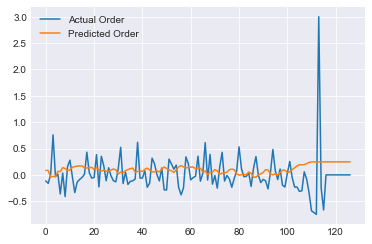

In [82]:
plt.plot(y_test[-127:], label = "Actual Order")
plt.plot(y_pred[-127:], label = "Predicted Order")
plt.legend()
plt.show()

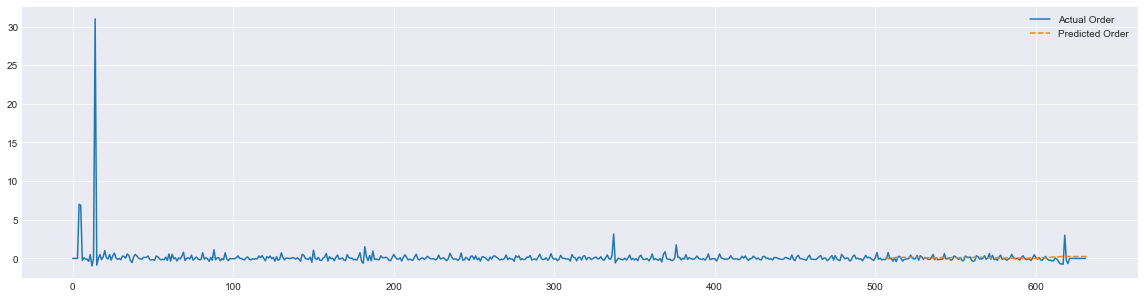

In [83]:
plt.figure(figsize = (20, 5))
plt.plot(np.append(y_train, y_test), label = "Actual Order")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Predicted Order")
plt.legend()
plt.show()

In [84]:
model = ARIMA(y_test, order = (1, 0, 1))

In [85]:
model_fit = model.fit(disp = 5)

In [86]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  127
Model:                     ARMA(1, 1)   Log Likelihood                 -47.779
Method:                       css-mle   S.D. of innovations              0.352
Date:                Mon, 07 Sep 2020   AIC                            103.558
Time:                        20:17:52   BIC                            114.935
Sample:                             0   HQIC                           108.180
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.015      0.504      0.614      -0.022       0.037
ar.L1.y        0.5347      0.144      3.712      0.000       0.252       0.817
ma.L1.y       -0.7813      0.101     -7.762      0.0

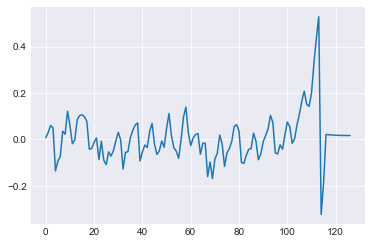

In [87]:
predictions = model_fit.predict(exog = X_test, typ = "levels")
plt.plot(predictions)

In [88]:
len(predictions)

127

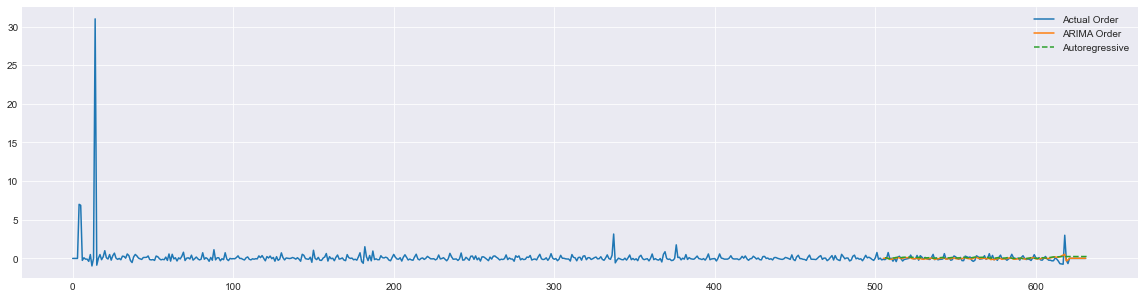

In [89]:
plt.figure(figsize = (20, 5))
plt.plot(np.append(y_train, y_test), label = "Actual Order")
plt.plot(np.append(np.array([None] * len(y_train)), predictions), label = "ARIMA Order")
plt.plot(np.append(np.array([None] * (len(y_train) + 1)), y_pred), "--", label = "Autoregressive")
plt.legend()
plt.show()

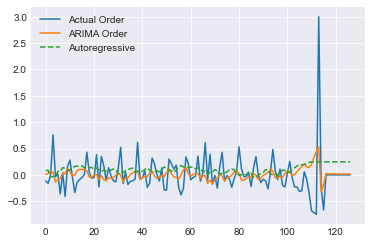

In [90]:
plt.plot(y_test, label = "Actual Order")
plt.plot(predictions, label = "ARIMA Order")
plt.plot(y_pred, "--", label = "Autoregressive")
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error

In [92]:
mean_squared_error(y_test, y_pred)

0.16033793498743237

In [93]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.4004221959225442